In [42]:
"""
This notebook analyze the historical campaign performance regarding the change of organic rank. The last part 
also paid attention to the sales attributed to a keyword.
"""

import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

import pandas as pd
import sys
import os
import time
from datetime import datetime
from datetime import timedelta  

from glob import glob
import os
from os import listdir
from os.path import isfile, join
import json

import urllib
# sys.path.insert(0,r'Desktop\vl_code\DataScience')
sys.path.insert(0,'/user/zhaoyu/tree')

import numpy as np
from multiprocessing import Pool, current_process
from importlib import reload
import PWLib as PWLib
reload(PWLib)
from PWLib.VTracker import VTracker

vt_key='Input V tracker API key here'

reload(PWLib)
from PWLib import AzureBlob
from PWLib import VL_Blobs
from PWLib.VL_Blobs import ASIN
from PWLib.Util import Util
from PWLib.Campaign import Campaign

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import itertools
import seaborn as sns
import ast

account_name= "vlst"
account_key= "Input VL blob API key here"

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

blob = ASIN(account_name,account_key)
marketplace = 'US'

import calendar
import re

import networkx as nx
from collections import Counter

In [2]:
def find_var_asins(asin, marketplace = 'US'): # return parent asins and a list of all related asins
    asin_data = blob.GetLatestASINInfo(marketplace=marketplace,asin=asin)
    if 'ParentASIN' in asin_data.keys():
        p_asin = asin_data['ParentASIN']
    else:
        p_asin = asin
    if 'VariationASINs' in asin_data.keys():
        v_asins = asin_data['VariationASINs']  
    else:
        v_asins = []
    v_asins.append(p_asin)
    return p_asin, v_asins

# Input a path and file name pattern, return a dataframe that merge all the csv files, and a list that stores the name
# of the files that are empty (zero rows)
def merge_csv_in_folders(root_path = './campaign_processed_v3/', pattern='_slope.csv'):
    existing_names = listdir(root_path)
    file_list = [root_path+s+'/'+s+pattern for s in existing_names]
    df_list = []
    empty_list = []
    for x in file_list:
        try:
            df_t = pd.read_csv(x)
            df_list.append(df_t)
        except:
            empty_list.append(x)
    merge_df = pd.concat(df_list, axis=0, ignore_index=True, sort=False)
    return merge_df, empty_list

########## get the asin info for the the variation asin with nearest date
def get_asin_for_row(row, date_pos='start', blob=blob, marketplace=marketplace, t_thresh=5, save_path = './asin_json/'): # date_pos should be start/end
    try:
        if date_pos == 'start':
            from_date = pd.to_datetime(min(row['campaign_dates']))
        elif date_pos == 'end':
            from_date = pd.to_datetime(max(row['campaign_dates']))
        else:
            print('Invalid date_pos input')

        most_common_asin = row['most_common_asin']
        parent_asin = row['parent_asin']
        row_id = row['row_id']

        asin_list = row['variation_asins']

        # always try to get the asin for most common asin if its within 3 days

        if len(asin_list)<=2:
            asin = asin_list[0]
            used_blob_name, used_dt = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=from_date)
            used_t_diff = used_df - from_date
        elif len(asin_list) > 2:
            asin = most_common_asin
            used_blob_name, used_dt = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=from_date)
            used_t_diff = used_dt - from_date
            if used_blob_name is not None:
                if abs(used_t_diff.days)>t_thresh:
                    asin_list.remove(most_common_asin)
                    asin_list.remove(parent_asin)
                    avai_date_list = []
                    blob_name_list = []
                    for asin in asin_list:
                        bl, d = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=from_date)
                        if bl is not None:
                            avai_date_list.append(pd.to_datetime(d))
                            blob_name_list.append(bl)
                    if len(avai_date_list)>0:
                        time_diff = []
                        for i in range(len(avai_date_list)):
                            time_diff.append(avai_date_list[i] - from_date)
                        time_diff_abs = [abs(x) for x in time_diff]
                        if min(time_diff_abs).days <= t_thresh:
                            nearest_date_idx = time_diff_abs.index(min(time_diff_abs))
                            used_blob_name = blob_name_list[nearest_date_idx]
                            used_t_diff = time_diff[nearest_date_idx]

        if used_blob_name is not None:
            asin_data = blob.GetSpecificAsinData(used_blob_name)
            asin_data['row_id'] = int(row_id)
            asin_data['time_diff_day'] = int(used_t_diff.days)
            asin_data['date_pos'] = date_pos

            js = json.dumps(asin_data)
            fn = used_blob_name.split('/')[-1]
            f = open(save_path + str(row_id) + fn,"w")
            f.write(js)
            f.close()

            return asin_data
    except:
        pass

# if the dataframe treat a column that stores list to be a string, convert it back
def string_to_list(df, cols):
    for col in cols:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x))
    return df

# merge a list of dictionarys with the same keys to a dataframe, each dictionary as one row
def merge_dicts_to_df(list_of_dicts):
    v_list = list_of_dicts
    data = v_list[0]
    df_asin = pd.DataFrame([data], columns=data.keys())
    if len(v_list) > 1:
        for i in range(1, len(v_list)):
            data = v_list[i]
            df_t = pd.DataFrame([data], columns=data.keys())
            df_asin = pd.concat([df_asin, df_t], axis=0, ignore_index=True, sort=False)
    return df_asin

def most_common(lst): # find the most common element in a list
    return max(set(lst), key=lst.count)

def cal_purity(lst): # calculate the share of most common elemet in a list
    most1 = max(set(lst), key=lst.count)
    sub_lst = [x for x in lst if (x==most1)]
    return len(sub_lst)/len(lst)

    
    

In [3]:
# read in the seller summary
seller_info = pd.read_csv('seller_camp_info.csv')
seller_info = seller_info.sort_values(['num_of_asins', 'num_of_keywords'], ascending=[False, False])
seller_info = seller_info.reset_index(drop=True)

In [4]:
# c = Campaign(marketplace,account_name,account_key)
# our_seller_list = c.GetSellerList()
# # seller_info['seller'][0]
# seller = 'A321X3MMVH8OEI'
# date_from = pd.to_datetime('04-26-2019')
# date_to =   pd.to_datetime('04-27-2019')
# d = c.GetCampaignData(seller=seller,
#                             date_from = date_from,
#                             date_to = date_to,
#                             Get_Asin=True,
#                             Get_ProductAd=False,
#                             Get_Keyword=False,
#                             Get_Campaign=False,
#                             Get_AdGroup=False,
#                             Get_ProductAttributeTargeting=False,

#                             Get_SponsoredProducts=True,
#                             Get_SponsoredBrands=False,

#                             Get_Suffix_Query=False,
#                             Get_Suffix_Placement=False)

In [8]:
############# these part of code preprocess the slope data, the processed data has already been saved, so it can be directly
##### loaded without runnning this part.
# slope_df, empty_list = merge_csv_in_folders()
# len(empty_list) ## 869
# slope_df.shape ## (45240, 10)
# slope_df['vt_purity'] = slope_df['record_asin'].apply(lambda x:cal_purity(x))
# slope_df['avg_rank'] = slope_df['ranks'].apply(lambda x: np.mean(x))
# slope_df['row_id'] = slope_df.index
# slope_df = string_to_list(df = slope_df, cols = ['campaign_dates', 'num_ads', 'rank_dates','ranks','record_asin','variation_asins'])

In [4]:
# slope_df.to_pickle("camp_slope_df.pkl")

# load in the saved processed campaign data with slope
slope_df = pd.read_pickle('camp_slope_df.pkl')

In [5]:
slope_df.head(2)

,campaign_dates,keyword,num_ads,parent_asin,rank_dates,ranks,record_asin,seller,slope,variation_asins,vt_purity,avg_rank,row_id
0,"[2019-04-20, 2019-04-22, 2019-04-23, 2019-04-2...",candy dispenser,"[2, 2, 2, 2, 2, 2]",B07HJDPLW9,"[2019-04-21, 2019-04-24, 2019-04-25, 2019-04-2...","[4, 4, 4, 2, 5, 3]","[B00D5XWRDW, B00D5XWRDW, B00D5XWRDW, B00D5XWRD...",A2YL96OOFKYQWA,-0.009412,"[B07HJDR49B, B00D5XWRDW, B07HJDPLW9]",1.0,3.666667,0
1,"[2019-06-03, 2019-06-04, 2019-06-06, 2019-06-0...",candy dispenser,"[1, 3, 2, 4, 3]",B07HJDPLW9,"[2019-06-06, 2019-06-07, 2019-06-08, 2019-06-0...","[4, 4, 3, 3, 3]","[B00D5XWRDW, B00D5XWRDW, B00D5XWRDW, B00D5XWRD...",A2YL96OOFKYQWA,-0.352941,"[B07HJDR49B, B00D5XWRDW, B07HJDPLW9]",1.0,3.400000,1


In [6]:
# calculate the most common asin for a campaign, that is, the asin that shows up most frequently from V tracker
slope_df['most_common_asin'] = slope_df['record_asin'].apply(lambda x: most_common(x))

In [7]:
# calculate the scaled slope: slope/average rank of the asin during campaign period
def scaled_slope(row):
    slp = row['slope']
    average_rank = np.mean(row['ranks'])
    return slp/average_rank
slope_df['scaled_slope'] = slope_df.apply(lambda x:scaled_slope(x), axis=1)

In [8]:
## vt_purity = 1 when all the ranks from v-tracker are from the same asin
pure_slope_df = slope_df[slope_df['vt_purity']==1]
pure_slope_df.shape

(29334, 15)

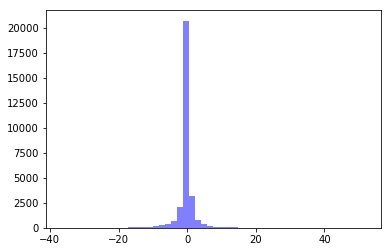

In [112]:
## Plot the distribution of the slope
%matplotlib inline

n, bins, patches = plt.hist(pure_slope_df['slope'], 50, facecolor='blue', alpha=0.5)
plt.show()

In [14]:
pure_slope_df['slope'].mean() # average of the slope

-0.13341680538688755

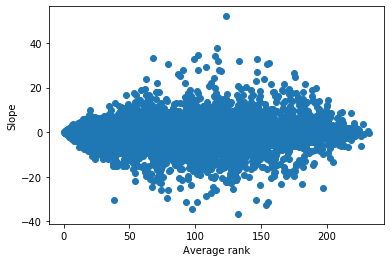

In [155]:
## Plot Slope vs average rank
plt.scatter(pure_slope_df['avg_rank'], pure_slope_df['slope'])
plt.xlabel('Average rank')
plt.ylabel('Slope')
plt.show()

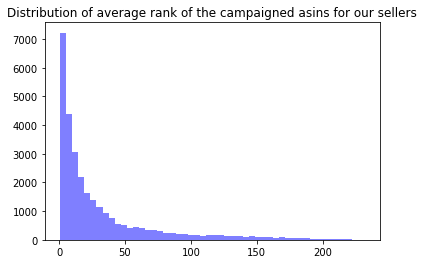

In [366]:
n, bins, patches = plt.hist(pure_slope_df['avg_rank'], 50, facecolor='blue', alpha=0.5)
plt.title('Distribution of average rank of the campaigned asins for our sellers')
plt.show()

## The better the rank position, the higher the relative (compared to its rank position ) fluctuation we can expect.

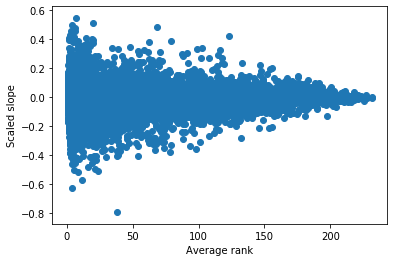

In [154]:
## plot the relationship between average rank vs scaled slope
plt.scatter(pure_slope_df['avg_rank'], pure_slope_df['scaled_slope'])
plt.xlabel('Average rank')
plt.ylabel('Scaled slope')
plt.show()

In [36]:
# ######## get the asin informaton
########## This has already been processed (it takes a day) and the processed data is saved as
########## 'camp_start_asin_df.pkl' and 'camp_end_asin_df.pkl' what are the asin information at the beginning and end of a campaign
########## Later analysis can directly load the pickled data

# row_ls = [slope_df.loc[i] for i in slope_df.index]

# n_jobs = 15    # You can change this based on your machine

# with Pool(n_jobs) as p:
#     asin_start_ls = p.map(get_asin_for_row, row_ls)
    
# asin_start_ls = [i for i in asin_start_ls if i]
# start_asin_df = merge_dicts_to_df(asin_start_ls)

# start_asin_df.to_pickle("camp_start_asin_df.pkl")

# ########## get the asin info for the the variation asin with nearest date
# def get_asin_for_row2(row, date_pos='end', blob=blob, marketplace=marketplace, t_thresh=5, save_path = './asin_json_end/'): # date_pos should be start/end
#     try:
#         if date_pos == 'start':
#             from_date = pd.to_datetime(min(row['campaign_dates']))
#         elif date_pos == 'end':
#             from_date = pd.to_datetime(max(row['campaign_dates']))
#         else:
#             print('Invalid date_pos input')

#         most_common_asin = row['most_common_asin']
#         parent_asin = row['parent_asin']
#         row_id = row['row_id']

#         asin_list = row['variation_asins']

#         # always try to get the asin for most common asin if its within 3 days

#         if len(asin_list)<=2:
#             asin = asin_list[0]
#             used_blob_name, used_dt = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=from_date)
#             used_t_diff = used_df - from_date
#         elif len(asin_list) > 2:
#             asin = most_common_asin
#             used_blob_name, used_dt = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=from_date)
#             used_t_diff = used_dt - from_date
#             if used_blob_name is not None:
#                 if abs(used_t_diff.days)>t_thresh:
#                     asin_list.remove(most_common_asin)
#                     asin_list.remove(parent_asin)
#                     avai_date_list = []
#                     blob_name_list = []
#                     for asin in asin_list:
#                         bl, d = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=from_date)
#                         if bl is not None:
#                             avai_date_list.append(pd.to_datetime(d))
#                             blob_name_list.append(bl)
#                     if len(avai_date_list)>0:
#                         time_diff = []
#                         for i in range(len(avai_date_list)):
#                             time_diff.append(avai_date_list[i] - from_date)
#                         time_diff_abs = [abs(x) for x in time_diff]
#                         if min(time_diff_abs).days <= t_thresh:
#                             nearest_date_idx = time_diff_abs.index(min(time_diff_abs))
#                             used_blob_name = blob_name_list[nearest_date_idx]
#                             used_t_diff = time_diff[nearest_date_idx]

#         if used_blob_name is not None:
#             asin_data = blob.GetSpecificAsinData(used_blob_name)
#             asin_data['row_id'] = int(row_id)
#             asin_data['time_diff_day'] = int(used_t_diff.days)
#             asin_data['date_pos'] = date_pos

#             js = json.dumps(asin_data)
#             fn = used_blob_name.split('/')[-1]
#             f = open(save_path + str(row_id) + fn,"w")
#             f.write(js)
#             f.close()

#             return asin_data
#     except:
#         pass
    
# with Pool(n_jobs) as p:
#     asin_end_ls = p.map(get_asin_for_row2, row_ls)
# asin_end_ls = [i for i in asin_end_ls if i]
# end_asin_df = merge_dicts_to_df(asin_end_ls)
# end_asin_df.to_pickle("camp_end_asin_df.pkl")

In [9]:
### load back the data
start_asin_df = pd.read_pickle('camp_start_asin_df.pkl')
end_asin_df = pd.read_pickle('camp_end_asin_df.pkl')

In [10]:
#### Match Asin information with slope data by row_id
pure_slp_merge = pd.merge(pure_slope_df, start_asin_df, how='inner', on='row_id')
pure_slp_merge.shape

(15523, 99)

In [11]:
##### Print the numeric and catergoric columns
num_cols = []
for y in start_asin_df.columns:
    if(start_asin_df[y].dtype == np.float64 or start_asin_df[y].dtype == np.int64):
        num_cols.append(y)
print(num_cols)
num_cols = []
for y in start_asin_df.columns:
    if(start_asin_df[y].dtype != np.float64 and start_asin_df[y].dtype != np.int64):
        num_cols.append(y)
print(num_cols)

['BSR', 'CategoryID', 'NetProfit', 'OfferCountNew', 'OfferCountUsed', 'PackageHeight', 'PackageLength', 'PackageQuantity', 'PackageWeight', 'PackageWidth', 'Price', 'PriceNew', 'PriceNewFBA', 'ProfitMargin', 'Revenue', 'ReviewCount', 'ReviewRate', 'ReviewRating', 'Sales', 'SalesLastYear', 'SalesToReviews', 'SellerCount', 'UnitMargin', 'UPC', 'StarRating', 'PriceChangeLastNinetyDays', 'ReviewCountChangeMonthly', 'SalesChangeLastNinetyDays', 'SalesYearOverYear', 'InitialCost', 'InitialNetProfit', 'InitialOrganicSalesProjection', 'InitialUnitsToOrder', 'OngoingOrganicSalesProjection', 'OngoingUnitsToOrder', 'PromotionDuration', 'PromotionUnitsDaily', 'PromotionUnitsTotal', 'row_id', 'time_diff_day', 'PriceAmazon', 'OfferCountRefurbished', 'OfferCountCollectible']
['IDBlobs', 'At', 'BestSellerRankings', 'Brand', 'BuyBoxSellerID', 'BuyBoxSellerIDs', 'BuyBoxSellerName', 'Category', 'Categories', 'Description', 'Features', 'Fees', 'FrequentlyBoughtTogether', 'FirstListed', 'Fulfillment', 'Ima

In [12]:
############### This part defines many functions to preprocess the features

def isbuybox(row): # check if a ASIN is the buybox seller
    if pd.isnull(row['BuyBoxSellerID']):
        return 'Unknown'
    else:
        if row['BuyBoxSellerID'] == row['seller']:
            return 'yes'
        else:
            return 'no'
def cal_len(cell): # calculate the length (number of characters) of one cell in the ASIN data
    if isinstance(cell, str):
        return len(cell)
    elif isinstance(cell, list):
        len_sum = 0
        for sentence in cell:
            len_sum += len(sentence)
        return len_sum
    else:
        return 0

def num_asin(cell): # calculate the number of variation Asins
    if isinstance(cell, list):
        return len(cell)
    else:
        return np.NaN

def find_total_fee(cell): # Sum up all items for the field "Fee"
    if isinstance(cell, dict):
        if 'Total' in cell.keys():
            return cell['Total']
        else:
            return np.NaN
    else:
        return np.NaN

def process_alert(a): # generate dummy variable to indicate whether a ASIN has a certain alert
    alerts = ['The review volume is generally exceeding the sales volume.',
             'The average price for this product is very low. We suggest avoiding this product unless you are able to source and ship with a satisfactory margin.',
             'The average review volume is extremely high which makes a high barrier to entry.',
             'Amazon is an active seller for this product.',
             'There are popular brand name sellers to compete with for this product market.']
    if isinstance(a, list):
        ReviewMoreSales = int(alerts[0] in a)
        LowPrice = int(alerts[1] in a)
        HighBarrier = int(alerts[2] in a)
        ActiveSeller = int(alerts[3] in a)
        PopularCompete = int(alerts[4] in a)
    else:
        ReviewMoreSales = 0
        LowPrice = 0
        HighBarrier = 0
        ActiveSeller = 0
        PopularCompete = 0
    return [ReviewMoreSales, LowPrice, HighBarrier, ActiveSeller, PopularCompete]

def process_warning(a): # generate dummy variable to indicate whether a ASIN has a certain warning
    warnings = ['The average review volume is high which makes a high barrier to entry.',
                 'It looks like the price has been dropping for this product. Make sure you are not getting into a market that is cannibalizing profit margin',
                 'This product appears to be a seasonal item.']
    if isinstance(a, list):
        HighBarrierWarning = int(warnings[0] in a)
        PriceDrop = int(warnings[1] in a)
        Seasonal = int(warnings[2] in a)
    else:
        HighBarrierWarning = 0
        PriceDrop = 0
        Seasonal = 0
    return [HighBarrierWarning, PriceDrop, Seasonal]

def process_tip(a): # generate dummy variable to indicate whether a ASIN has a certain tip
    tips = ['Be careful when sourcing this product as there are low rated products. Looks like a good opportunity to improve the quality standard of this product!',
             'There are products with a high review rating. Be sure to take your time to source a high quality product!',
             'This product is increasing in popularity.',
             'You may want to consider bundling this item.']
    if isinstance(a, list):
        LowRatedProduct = int(tips[0] in a)
        HighReviewExist = int(tips[1] in a)
        PopularityIncrease = int(tips[2] in a)
        ConsiderBundling = int(tips[3] in a)
    else:
        LowRatedProduct = 0
        HighReviewExist = 0
        PopularityIncrease = 0
        ConsiderBundling = 0
    return [LowRatedProduct, HighReviewExist, PopularityIncrease, ConsiderBundling]


def month_to_num_list(m_str): # Convert a list of string months to numeric months
    month_to_num = {v: k for k,v in enumerate(calendar.month_name)}
    m_ls = []
    if isinstance(m_str, str):
        if ' - ' in m_str:
            m_split = m_str.split(' - ')
            start_n = month_to_num[m_split[0]]
            end_n = month_to_num[m_split[1]]
            if end_n < start_n:
                for i in range(start_n, 13):
                    m_ls.append(i)
                for i in range(1, end_n+1):
                    m_ls.append(i)
            else:
                for i in range(start_n, end_n+1):
                    m_ls.append(i)

        else:
            m_ls.append(month_to_num[m_str])
        return m_ls
    else:
        return np.NaN


def InBestSalesPeriod(row):  # return 1 if in BestsalesPeriod
    campaign_dates = row['campaign_dates']
    best_m = month_to_num_list(row['BestSalesPeriod'])
    campaign_m = [pd.to_datetime(x).month for x in campaign_dates]
    campaign_m = np.unique(campaign_m)
    if isinstance(best_m, list):
        for i in campaign_m:
            if i in best_m:
                output = 1
                break
            else:
                output = 0
    else:
        output = np.NaN
    return output
                
def last10slope(a): # fit a linear line of the values (price, sales, BSR, etc.) for last ten days, return the slope of the fit
    if isinstance(a, dict):
        vs = a['Values']
        if len(vs) >= 10:
            last10 = vs[-10:]
            X = np.array(range(1,11)).reshape(-1,1)
            Y = np.array(last10).reshape(-1,1)
            regressor = LinearRegression()
            regressor.fit(X, Y)
            slope = regressor.coef_[0][0]
            output = slope/np.mean(last10)
        else:
            output = np.NaN
    else:
        output = np.NaN
    return output

def process_coupon(row): # Based on the 'Coupon' column, if there is a coupon, return the % off
    a = row['Coupons']
    try:
        c = a[0]
        if "%" in c:
            m = re.search('Save (.+?)%', c).group(1)
            return float(m)/100
        elif "$" in c:
            m = re.search('\$(.+?) with', c).group(1)
            p = row['Price']
            return float(m)/p
        else:
            return 0
    except:
        return 0
        


def new_features(df, cols): # cols = [the columns that we want to process], then call this func to process them together
    if 'BuyBoxSellerID' in cols:
        df['isBuyBoxSeller'] = df.apply(isbuybox, axis = 1)
    if 'Description' in cols:
        df['Description_length'] = df['Description'].apply(cal_len)
    if 'Features' in cols:
        df['Feature_length'] = df['Features'].apply(cal_len)
    if 'Fees' in cols:
        df['Total_fee'] = df['Fees'].apply(find_total_fee)
    if 'ImageUrls' in cols:
        df['Num_figures'] = df['ImageUrls'].apply(cal_len)
    if 'Title' in cols:
        df['Title_length'] = df['Title'].apply(cal_len)
    if 'variation_asins' in cols:
        df['Num_of_Asins'] = df['variation_asins'].apply(num_asin)
    if 'Alerts' in cols:
        a_out = df['Alerts'].apply(process_alert)
        a_out = np.array(list(a_out), np.int32)
        df['ReviewMoreSales'], df['LowPrice'], df['HighBarrier'], df['ActiveSeller'], df['PopularCompete'] = a_out[:,0], a_out[:,1], a_out[:,2], a_out[:,3], a_out[:,4]
    if 'Warnings' in cols:
        a_out = df['Warnings'].apply(process_warning)
        a_out = np.array(list(a_out), np.int32)
        df['HighBarrierWarning'], df['PriceDrop'], df['Seasonal'] = a_out[:,0], a_out[:,1], a_out[:,2]
    if 'Tips' in cols:
        a_out = df['Tips'].apply(process_tip)
        a_out = np.array(list(a_out), np.int32)
        df['LowRatedProduct'], df['HighReviewExist'], df['PopularityIncrease'], df['ConsiderBundling'] = a_out[:,0], a_out[:,1], a_out[:,2], a_out[:,3]
    if 'BestSalesPeriod' in cols:
        df['InBestSalesPeriod'] = df.apply(InBestSalesPeriod, axis = 1)
    if 'BSRDailyAverages' in cols:
        df['BSRLast10SLope'] = df['BSRDailyAverages'].apply(last10slope)
    if 'PriceDailyAverages' in cols:
        df['PriceLast10SLope'] = df['PriceDailyAverages'].apply(last10slope)
    if 'ReviewCountDailyAverages' in cols:
        df['ReviewLast10SLope'] = df['ReviewCountDailyAverages'].apply(last10slope)
    if 'SalesDailyAverages' in cols:
        df['SalesLast10SLope'] = df['SalesDailyAverages'].apply(last10slope)
    if 'Coupons' in cols:
        df['CouponPercent'] = df.apply(process_coupon, axis = 1)
    return df


In [115]:
process_cols = ['BuyBoxSellerID','Description', 'Features', 'Fees', 'ImageUrls','Title', 'variation_asins','Alerts','Warnings',
              'Tips','BestSalesPeriod','BSRDailyAverages','PriceDailyAverages', 'ReviewCountDailyAverages','SalesDailyAverages',
              'Coupons']

### Preprocess the ASIN information to generate numeric features for modeling
pure_slp_merge = new_features(pure_slp_merge, cols=process_cols)
# pure_slp_merge = new_features(pure_slp_merge, cols=['variation_asins'])

### Add the search rank of the keywords

In [44]:
search_terms = pd.read_csv('Amazon Search Terms_US (05_26-06_01,2019).csv', header=1)
print(search_terms.shape)
search_terms.head(2)

(790333, 15)


,Department,Search Term,Search Frequency Rank,#1 Clicked ASIN,#1 Product Title,#1 Click Share,#1 Conversion Share,#2 Clicked ASIN,#2 Product Title,#2 Click Share,#2 Conversion Share,#3 Clicked ASIN,#3 Product Title,#3 Click Share,#3 Conversion Share
0,Amazon.com,wireless earbuds,1,B07NY79DYX,"Bluetooth Headphones,Wireless Earbuds,Bluetoot...",3.67%,0.06%,B07MXD73Z4,Bluetooth Headphones Wireless Earbuds Earphone...,3.07%,2.68%,B07FPG94RP,Bluetooth Earbuds Wireless Headphones Bluetoot...,2.65%,15.38%
1,Amazon.com,bluetooth headphones,2,B07RPF5H8K,Wireless Bluetooth Headphones-Wireless in-Ear ...,4.86%,0.00%,B07QCCXCDR,"Bluetooth Earbuds,Bluetooth Headphones,Wireles...",3.68%,0.03%,B07MXD73Z4,Bluetooth Headphones Wireless Earbuds Earphone...,3.25%,1.07%


In [45]:
import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' )
def find_search_rank(term): # find the search rank of a keyword, if not find in the data, return a very large number
    sub = search_terms['Search Frequency Rank'][search_terms['Search Term']==term]
    if len(sub) > 0:
        num_str = list(sub)[0]
        return locale.atoi(num_str)
    else:
        return 10000000


3677


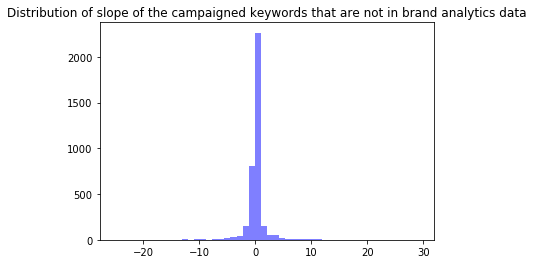

-0.015030459237907069


In [120]:
pure_slp_merge['KeywordSearchRank'] = pure_slp_merge['keyword'].apply(find_search_rank)
print(len(pure_slp_merge[pure_slp_merge['KeywordSearchRank']==10000000]))

pure_slp_notinsearch = pure_slp_merge[pure_slp_merge['KeywordSearchRank']==10000000]
n, bins, patches = plt.hist(pure_slp_notinsearch['slope'], 50, facecolor='blue', alpha=0.5)
plt.title('Distribution of slope of the campaigned keywords that are not in brand analytics data')
plt.show()
print(np.mean(pure_slp_notinsearch['slope']))

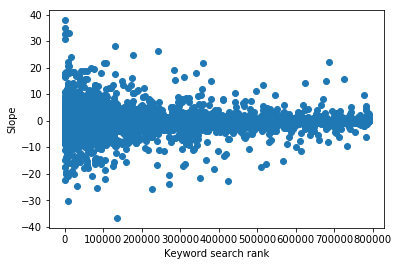

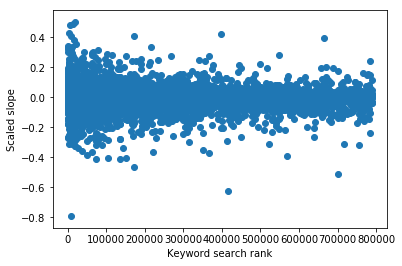

In [121]:
pure_slp_insearch = pure_slp_merge[pure_slp_merge['KeywordSearchRank']!=10000000]
plt.scatter(pure_slp_insearch['KeywordSearchRank'], pure_slp_insearch['slope'])
plt.xlabel('Keyword search rank')
plt.ylabel('Slope')
plt.show()
plt.scatter(pure_slp_insearch['KeywordSearchRank'], pure_slp_insearch['scaled_slope'])
plt.xlabel('Keyword search rank')
plt.ylabel('Scaled slope')
plt.show()

### Subset the data to only keep useful features

In [122]:
needed_obj_cols = ['isBuyBoxSeller', 'Category', 'Description_length', 'Feature_length', 'Total_fee', 
                   'Fulfillment', 'Num_figures', 'IsVariationWithSharedBSR', 'Title_length', 
                   'Num_of_Asins', 'ReviewMoreSales', 'LowPrice', 'HighBarrier', 'ActiveSeller', 'PopularCompete', 
                   'HighBarrierWarning', 'PriceDrop', 'Seasonal', 'LowRatedProduct','HighReviewExist', 'PopularityIncrease',
                   'ConsiderBundling', 'InBestSalesPeriod', 'IsNameBrand', 'SalesPattern', 'BSRLast10SLope', 'PriceLast10SLope',
                   'ReviewLast10SLope','SalesLast10SLope','CouponPercent', 'KeywordSearchRank']
needed_num_cols = ['slope','scaled_slope','avg_rank','BSR', 'NetProfit', 'OfferCountNew', 'OfferCountUsed', 'PackageHeight', 'PackageLength', 'PackageQuantity', 
               'PackageWeight', 'PackageWidth', 'Price', 'PriceNew', 'PriceNewFBA', 'ProfitMargin', 'Revenue', 'ReviewCount', 
               'ReviewRate', 'ReviewRating', 'Sales', 'SalesToReviews', 'SellerCount', 'UnitMargin', 
               'StarRating', 'ReviewCountChangeMonthly',  
               'InitialCost', 'InitialNetProfit', 'InitialOrganicSalesProjection', 'InitialUnitsToOrder', 
               'OngoingOrganicSalesProjection', 'OngoingUnitsToOrder', 'PromotionDuration', 'PromotionUnitsDaily', 
               'PromotionUnitsTotal', 'OfferCountRefurbished', 'OfferCountCollectible']
needed_all_cols = needed_obj_cols + needed_num_cols

pure_df = pure_slp_merge[needed_all_cols]
pure_df[['InBestSalesPeriod', 'OfferCountNew', 'OfferCountUsed','OfferCountRefurbished','OfferCountCollectible']] = pure_df[['InBestSalesPeriod', 
                                                                                                                             'OfferCountNew', 'OfferCountUsed','OfferCountRefurbished','OfferCountCollectible']].fillna(value=0)
pure_df[['SalesPattern']] = pure_df[['SalesPattern']].fillna(value='Unknown')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [123]:
pure_df = pure_df.dropna(axis = 0)
pure_df[['IsVariationWithSharedBSR', 'IsNameBrand']] = (pure_df[['IsVariationWithSharedBSR', 'IsNameBrand']]).astype(int)
pure_df['isBuyBoxSeller'] = (pure_df['isBuyBoxSeller'] == 'yes').astype(int)
pure_df['Fulfillment'] = (pure_df['Fulfillment'] == 'AMZN').astype(int)
print(pure_df.info(max_cols=200))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13013 entries, 0 to 15522
Data columns (total 68 columns):
isBuyBoxSeller                   13013 non-null int64
Category                         13013 non-null object
Description_length               13013 non-null int64
Feature_length                   13013 non-null int64
Total_fee                        13013 non-null float64
Fulfillment                      13013 non-null int64
Num_figures                      13013 non-null int64
IsVariationWithSharedBSR         13013 non-null int64
Title_length                     13013 non-null int64
Num_of_Asins                     13013 non-null int64
ReviewMoreSales                  13013 non-null int32
LowPrice                         13013 non-null int32
HighBarrier                      13013 non-null int32
ActiveSeller                     13013 non-null int32
PopularCompete                   13013 non-null int32
HighBarrierWarning               13013 non-null int32
PriceDrop               

In [133]:
#### Encode the catergorical features
encode_method = 'number' ## number or dummy
if encode_method == 'number':
    labelencoder_X = LabelEncoder()
    pure_df['Category'] = labelencoder_X.fit_transform(pure_df['Category'])
    pure_df['SalesPattern'] = labelencoder_X.fit_transform(pure_df['SalesPattern'])
elif encode_method == 'dummy':
    pure_df = pd.get_dummies(pure_df, columns=['Category', 'SalesPattern'], drop_first=True)

In [136]:
pure_df.describe()

,isBuyBoxSeller,Category,Description_length,Feature_length,Total_fee,Fulfillment,Num_figures,IsVariationWithSharedBSR,Title_length,Num_of_Asins,ReviewMoreSales,LowPrice,HighBarrier,ActiveSeller,PopularCompete,HighBarrierWarning,PriceDrop,Seasonal,LowRatedProduct,HighReviewExist,PopularityIncrease,ConsiderBundling,InBestSalesPeriod,IsNameBrand,SalesPattern,BSRLast10SLope,PriceLast10SLope,ReviewLast10SLope,SalesLast10SLope,CouponPercent,KeywordSearchRank,slope,scaled_slope,avg_rank,BSR,NetProfit,OfferCountNew,OfferCountUsed,PackageHeight,PackageLength,PackageQuantity,PackageWeight,PackageWidth,Price,PriceNew,PriceNewFBA,ProfitMargin,Revenue,ReviewCount,ReviewRate,ReviewRating,Sales,SalesToReviews,SellerCount,UnitMargin,StarRating,ReviewCountChangeMonthly,InitialCost,InitialNetProfit,InitialOrganicSalesProjection,InitialUnitsToOrder,OngoingOrganicSalesProjection,OngoingUnitsToOrder,PromotionDuration,PromotionUnitsDaily,PromotionUnitsTotal,OfferCountRefurbished,OfferCountCollectible
count,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,1.301300e+04,13013.000000,13013.000000,13013.000000,1.301300e+04,13013.000000,13013.000000,13013.000000,1.301300e+04,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000,13013.000000
mean,0.954891,11.255437,1192.199647,1162.568893,9.421757,0.020902,98.529240,0.000538,156.339430,7.418120,0.268040,0.115884,0.167141,0.020902,0.014293,0.121187,0.119803,0.160071,0.054791,0.478060,0.080689,0.072389,0.101975,0.014293,1.528395,0.002206,-7.317300e-05,0.003327,-0.001545,0.012909,2.452891e+06,0.025398,-0.001287,30.484997,2.393647e+04,14915.458923,1.767924,0.290863,2.974030,10.503586,2.159533,2.184857,6.534032,28.530831,28.253341,28.550088,63.006905,22403.167496,523.454699,2.255070,4.394774,895.965189,5.420861,1.700146,19.109074,2.674018,14.854787,9057.395715,689.002378,806.387074,1453.036656,2239.922693,2239.922693,10.696995,29.867671,646.649581,0.000615,0.005610
std,0.207551,5.299129,629.559638,514.866382,8.622575,0.143062,19.039425,0.023188,42.426233,10.746957,0.442955,0.320098,0.373116,0.143062,0.118702,0.326356,0.324744,0.366686,0.227581,0.499538,0.272367,0.259141,0.302627,0.118702,0.896022,0.057143,8.756775e-03,0.019933,0.050699,0.033424,4.146194e+06,2.622601,0.057985,40.774060,5.104274e+04,35626.776152,2.624975,0.944514,2.220238,8.325342,13.707371,4.761482,4.215379,33.721424,33.202771,33.715385,9.426833,49854.315947,857.792344,147.637136,0.360334,1584.819003,67.773919,1.827102,25.997790,1.301961,39.177727,27796.766018,14088.961471,1426.332614,3489.131411,3962.046867,3962.046867,6.756993,52.836428,2092.058970,0.024788,0.074691
min,0.000000,0.000000,0.000000,0.000000,3.410000,0.000000,0.000000,0.000000,22.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.440098,-9.986719e-02,-0.356702,-0.340474,0.000000,1.900000e+01,-36.674419,-0.790308,0.681818,4.000000e+00,-174.660000,1.000000,0.000000,-0.039400,-0.039400,-1.000000,-0.002200,-0.039400,2.780000,2.390000,4.990000,-51.080000,0.000000,1.000000,-10623.080000,2.400000,0.000000,0.000000,1.000000,-1.420000,1.000000,-846.500000,0.000000,-435430.860000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.000000,642.000000,774.000000,5.330000,0.000000,105.000000,0.000000,130.00000

## Building random forest model and get feature importance

In [137]:
# create a target value, 1 if slope is negative or zero, 0 otherwise 
pure_df['slope_label'] = pure_df['slope'].apply(lambda x:int(x<=0))

In [140]:
## Plot the importance of the features based on different target variables
## Also return the feature importance numbers in a dataframe
def rf_importance(target_v, input_df, small_data = False, figure_size=(10,27)): #target_v = 'slope_label', 'slope', 'scaled_slope'
    pure_df = input_df
    if target_v == 'scaled_slope':
        p_df1 = pure_df.drop(columns=['slope', 'slope_label'])
    elif target_v == 'slope':
        p_df1 = pure_df.drop(columns=['scaled_slope','slope_label'])
    else:
        p_df1 = pure_df.drop(columns=['scaled_slope','slope'])
    # Randomly select 1000 rows for testing, keep the rest for training
    if small_data:
        test = p_df1.sample(n=10)
    else:
        test=p_df1.sample(n=1000)
    train=p_df1.loc[~p_df1.index.isin(test.index)]

    train_x=train.loc[:,train.columns!=target_v]
    train_y=train[target_v]
    test_x=test.loc[:,test.columns!=target_v]
    test_y=test[target_v]
    #Random Forest
    if target_v == 'slope_label':
        rf=RandomForestClassifier(n_estimators=10,bootstrap=True, random_state=0) ## number of trees and number of layers/depth
    else:
        rf=RandomForestRegressor(n_estimators=10,bootstrap=True, random_state=0) ## number of trees and number of layers/depth
    rf.fit(train_x,train_y)
    rf_tr=rf.predict(train_x)
    rf_y=rf.predict(test_x)

    feature_importance = rf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_to_show = len(test_x.columns)
    indices = np.argsort(feature_importance)[-feature_to_show:]
    plt.figure(figsize=figure_size)
    plt.barh(np.arange(feature_to_show), feature_importance[indices],color='dodgerblue',alpha=.4)
    plt.yticks(np.arange(feature_to_show + 0.25), np.array(train_x.columns)[indices])
    plt.xlabel('Relative importance'), plt.title('Top Important Variables, target: '+target_v)
    plt.show()
    return list(train_x.columns), feature_importance

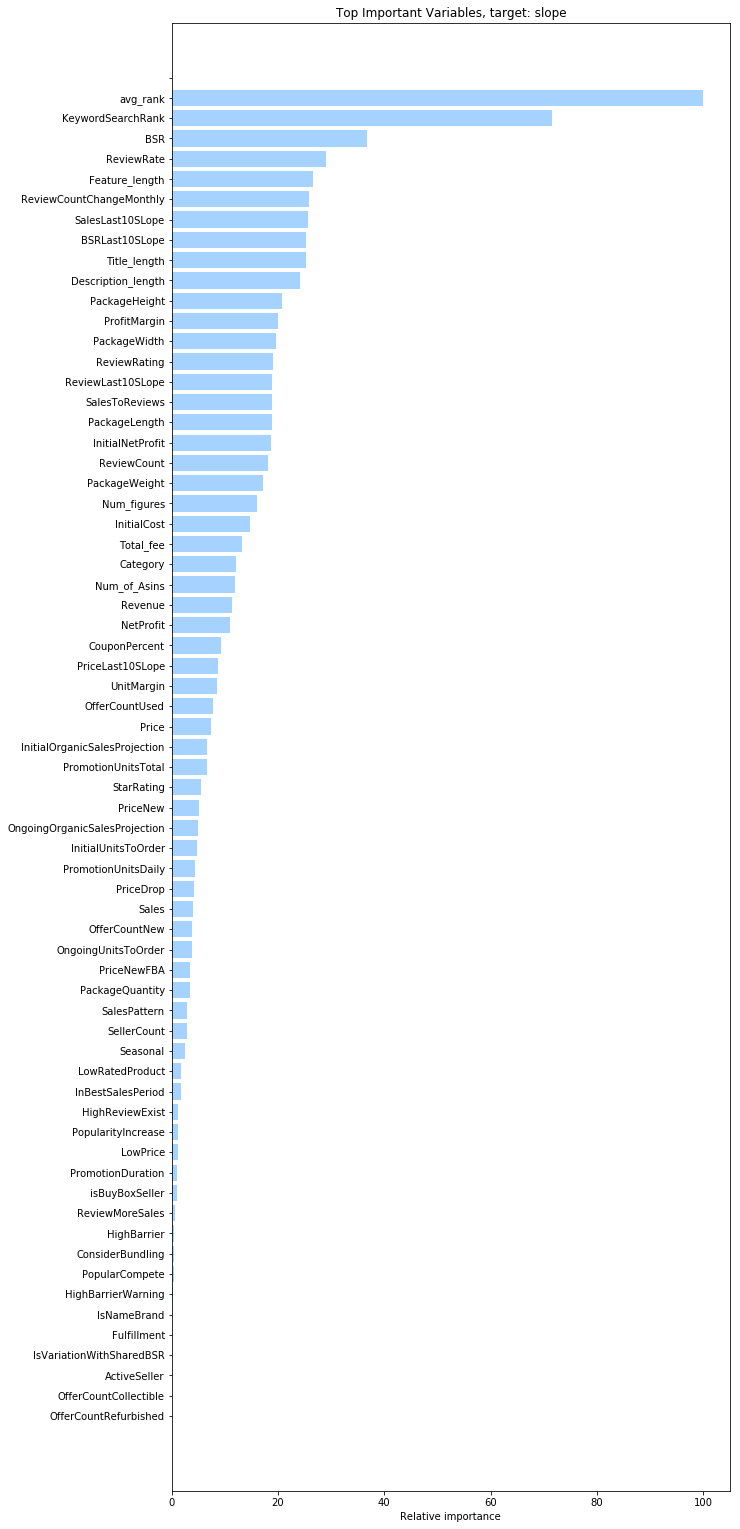

In [142]:
col_slope, imp_slope = rf_importance(target_v = 'slope', input_df=pure_df)

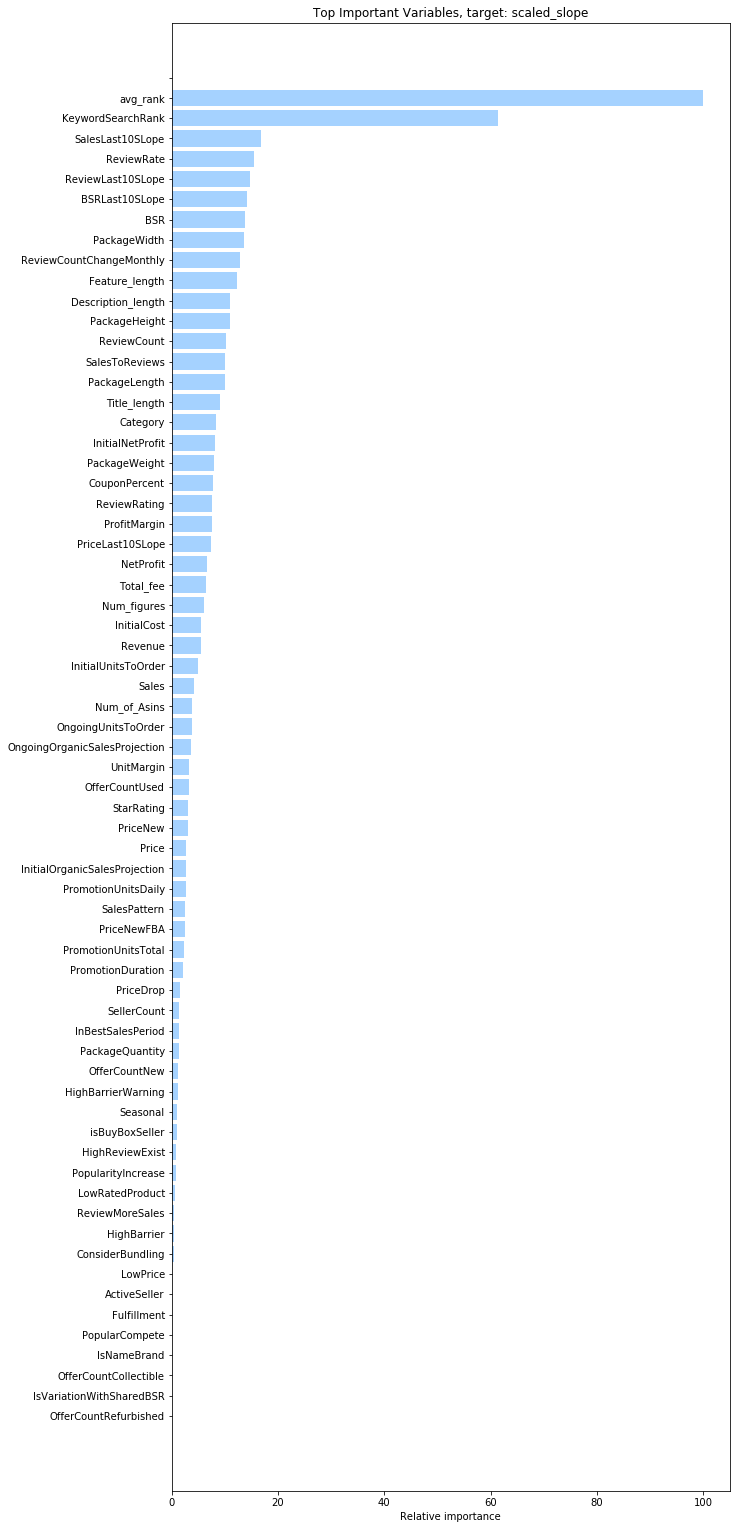

In [141]:
col_scaled, imp_scaled = rf_importance(target_v = 'scaled_slope', input_df=pure_df)

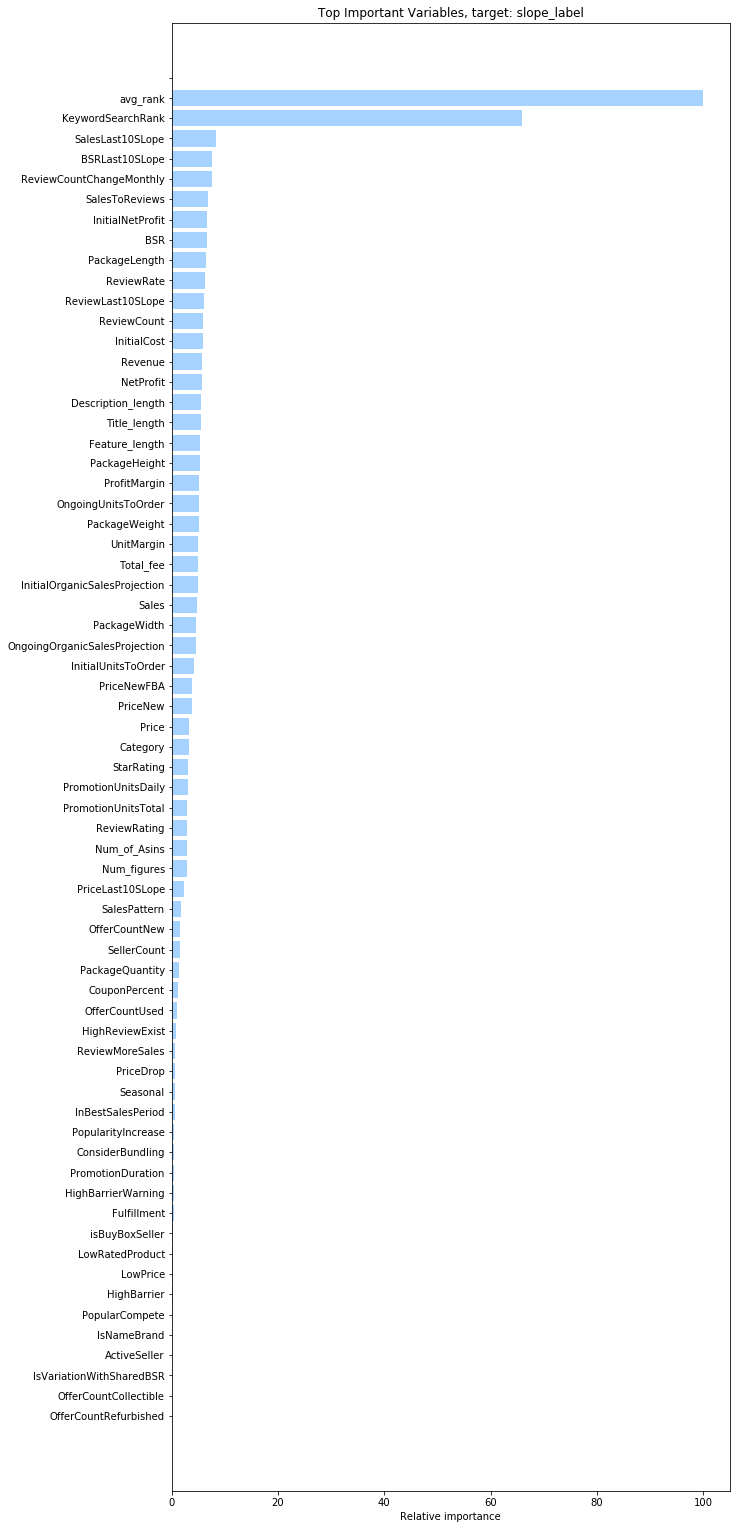

In [143]:
col_label, imp_label = rf_importance(target_v = 'slope_label', input_df=pure_df)

In [144]:
imp_df = pd.DataFrame(
{'Variable': col_label,
 'imp_slope': imp_slope,
 'imp_scaled': imp_scaled,
 'imp_label': imp_label
})

In [145]:
def imp_row_avg(row): # calculate the average of importance score using slope, scaled_slope and slope label (0-1) as the targets
    return np.mean([row['imp_slope'],row['imp_scaled'], row['imp_label']])
imp_df['avg_imp'] = imp_df.apply(imp_row_avg, axis=1)
imp_df = imp_df.sort_values(by=['avg_imp'], ascending=False)
imp_df['Importance_rank'] = range(1, len(imp_df)+1)
def find_corr(row): # find the correlation of one column with the 'slope'
    var = row['Variable']
    return pure_df['slope'].corr(pure_df[var])
imp_df['corr_with_slope'] = imp_df.apply(find_corr, axis=1)
    
imp_df.head(20)

,Variable,imp_slope,imp_scaled,imp_label,avg_imp,Importance_rank,corr_with_slope
31,avg_rank,100.000000,100.000000,100.000000,100.000000,1,0.067115
30,KeywordSearchRank,71.483086,61.379197,65.802227,66.221503,2,-0.006650
32,BSR,36.724816,13.737392,6.560162,19.007457,3,-0.056883
28,SalesLast10SLope,25.585116,16.758894,8.219439,16.854483,4,-0.018350
47,ReviewRate,28.952155,15.401219,6.173129,16.842168,5,-0.010976
25,BSRLast10SLope,25.300798,14.232606,7.531506,15.688304,6,0.011602
54,ReviewCountChangeMonthly,25.724409,12.824320,7.516727,15.355152,7,-0.012607
3,Feature_length,26.484304,12.284931,5.277470,14.682235,8,-0.009044
2,Description_length,24.060478,10.992992,5.547689,13.533720,9,0.006823
8,Title_length,25.174426,9.076775,5.456597,13.235933,10,-0.003221


In [146]:
imp_df.to_csv('campaign_importance.csv', index=False)

### Visualize the first two important features

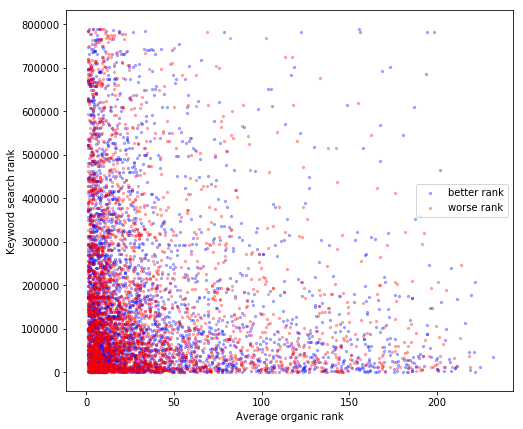

In [73]:
pure_slp_insearch = pure_df[pure_df['KeywordSearchRank']!=10000000]
cdict = {0: 'red', 1: 'blue'}
ldict = {0: 'worse rank', 1: 'better rank'}

fig, ax = plt.subplots(figsize=(8, 7))
for g in pure_slp_insearch['slope_label'].unique():
    ix = np.where(pure_slp_insearch['slope_label'] == g)
    ax.scatter(pure_slp_insearch['avg_rank'].loc[ix], pure_slp_insearch['KeywordSearchRank'].loc[ix], c = cdict[g], 
               label = ldict[g], s = 5, alpha=0.3)
plt.xlabel('Average organic rank')
plt.ylabel('Keyword search rank')
ax.legend()
# ax.set_xlim(0, 50)
# ax.set_ylim(0, 200000)
plt.show()

<IPython.core.display.Javascript object>


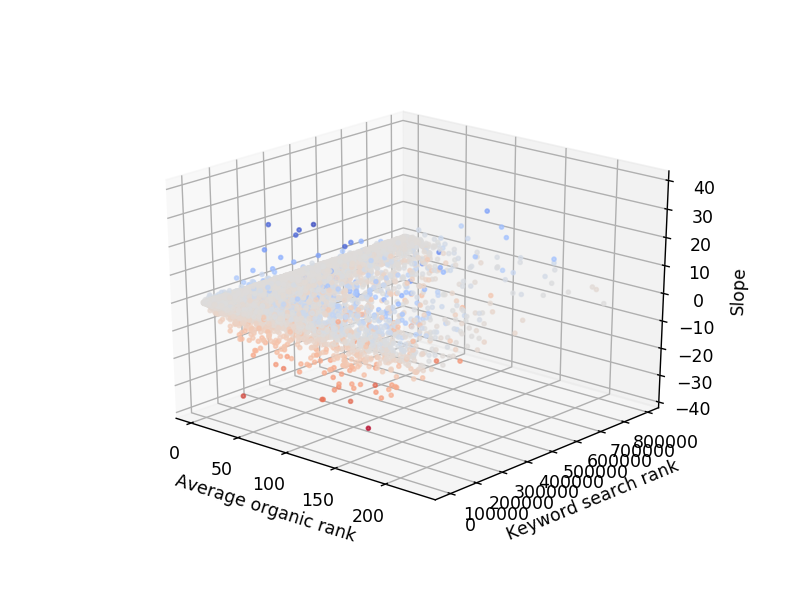

Text(0.5, 0, 'Slope')

In [95]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d    

%matplotlib notebook

ax = plt.axes(projection='3d')
ax.scatter3D(pure_slp_insearch['avg_rank'], pure_slp_insearch['KeywordSearchRank'], pure_slp_insearch['slope'], 
             c= -pure_slp_insearch['slope'], cmap='coolwarm', s = 5, alpha=0.7)
ax.set_xlabel('Average organic rank')
ax.set_ylabel('Keyword search rank')
ax.set_zlabel('Slope')

<IPython.core.display.Javascript object>


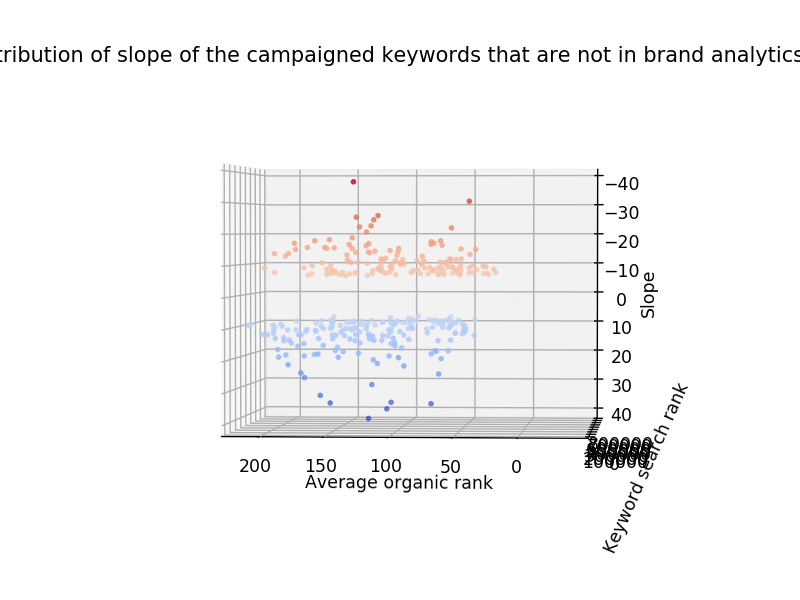

Text(0.5, 0, 'Slope')

In [96]:
pure_slp_largechange = pure_slp_insearch[abs(pure_slp_insearch['slope'])>=7]

%matplotlib notebook

ax = plt.axes(projection='3d')
ax.scatter3D(pure_slp_largechange['avg_rank'], pure_slp_largechange['KeywordSearchRank'], pure_slp_largechange['slope'], 
             c= -pure_slp_largechange['slope'], cmap='coolwarm', s = 5, alpha=0.7)
ax.set_xlabel('Average organic rank')
ax.set_ylabel('Keyword search rank')
ax.set_zlabel('Slope')

## Use CPC data to do the analysis

In [19]:
# merged campaign data from seller central
ad_merged = pd.read_pickle('ad_merged.pkl') 
search_merged = pd.read_pickle('search_merged.pkl')

In [125]:
################## Find a one-one match for asin-keyword pair from the campaign data from seller central
### it is treated as a 1-1 match only if for a day, for a asin-keyword record from the slope data, only one keyword record from search_merged
### and one asin record from ad_merged are found.

# slp_asins = pure_slp_merge['most_common_asin'].unique()
# print(ad_merged.shape)
# ad_match = ad_merged[ad_merged['Advertised ASIN'].isin(slp_asins)]
# print(ad_match.shape)

# (1867283, 28)
# (129052, 28)

# slp_cpc = pure_slp_merge.copy()
# search_cpc = search_merged.copy()
# slp_cpc['end_date'] = slp_cpc['campaign_dates'].apply(lambda x: x[-1])
# print(slp_cpc.shape)
# print(search_cpc.shape)
# for i in slp_cpc.index:
#     keyw = slp_cpc['keyword'].loc[i]
#     e_date = slp_cpc['end_date'].loc[i]
#     s_sub = search_cpc[(search_cpc['Customer Search Term']==keyw) & (search_cpc['Date']==e_date)]
#     if len(s_sub)!=1:
#         slp_cpc = slp_cpc.drop([i])
#         drop_idx = list(s_sub.index)
#         search_cpc = search_cpc.drop(drop_idx)
# print(slp_cpc.shape)
# print(search_cpc.shape)
# # (15523, 125)
# # (992073, 33)
# # (469, 125)
# # (968071, 33)

(1867283, 28)
(129052, 28)
(15523, 126)
(992073, 33)
(469, 126)
(968071, 33)


In [126]:
########## Join the cpc related data to the slope df
# search_needed = search_cpc[['Date','Customer Search Term', 'Impressions', 'Clicks','Click-Thru Rate (CTR)', 
#                             'Cost Per Click (CPC)', 'Spend']]

# search_needed['date'] = search_needed['Date'].apply(lambda x: str(x)[:10])
# slp_cpc = pd.merge(slp_cpc, search_needed, how='left', left_on=['keyword','end_date'], 
#                    right_on = ['Customer Search Term','date'])
# slp_cpc.info(max_cols=150)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 468
Data columns (total 134 columns):
campaign_dates                   469 non-null object
keyword                          469 non-null object
num_ads                          469 non-null object
parent_asin                      469 non-null object
rank_dates                       469 non-null object
ranks                            469 non-null object
record_asin                      469 non-null object
seller                           469 non-null object
slope                            469 non-null float64
variation_asins                  469 non-null object
vt_purity                        469 non-null float64
avg_rank                         469 non-null float64
row_id                           469 non-null int64
most_common_asin                 469 non-null object
scaled_slope                     469 non-null float64
IDBlobs                          469 non-null object
At                               469 non-nu

In [127]:
## save or reload the data
# slp_cpc.to_csv('slp_cpc.csv', index=False)
slp_cpc = pd.read_csv('slp_cpc.csv')

In [147]:
slp_cpc['slope_label'] = slp_cpc['slope'].apply(lambda x:int(x<=0))
imp_vars = list(imp_df['Variable'])[:20] # now only use the top 20 important features identified from previous part
cpc_vars = imp_vars + ['slope_label', 'slope', 'scaled_slope', 'Impressions', 'Clicks','Click-Thru Rate (CTR)', 
                       'Cost Per Click (CPC)', 'Spend']
slp_cpc_sub = slp_cpc[cpc_vars]
slp_cpc_sub = slp_cpc_sub.dropna(axis = 0)
slp_cpc_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 468
Data columns (total 28 columns):
avg_rank                    420 non-null float64
KeywordSearchRank           420 non-null int64
BSR                         420 non-null float64
SalesLast10SLope            420 non-null float64
ReviewRate                  420 non-null float64
BSRLast10SLope              420 non-null float64
ReviewCountChangeMonthly    420 non-null float64
Feature_length              420 non-null int64
Description_length          420 non-null int64
Title_length                420 non-null int64
ReviewLast10SLope           420 non-null float64
PackageWidth                420 non-null float64
PackageHeight               420 non-null float64
SalesToReviews              420 non-null float64
PackageLength               420 non-null float64
ReviewCount                 420 non-null float64
InitialNetProfit            420 non-null float64
ProfitMargin                420 non-null float64
PackageWeight        

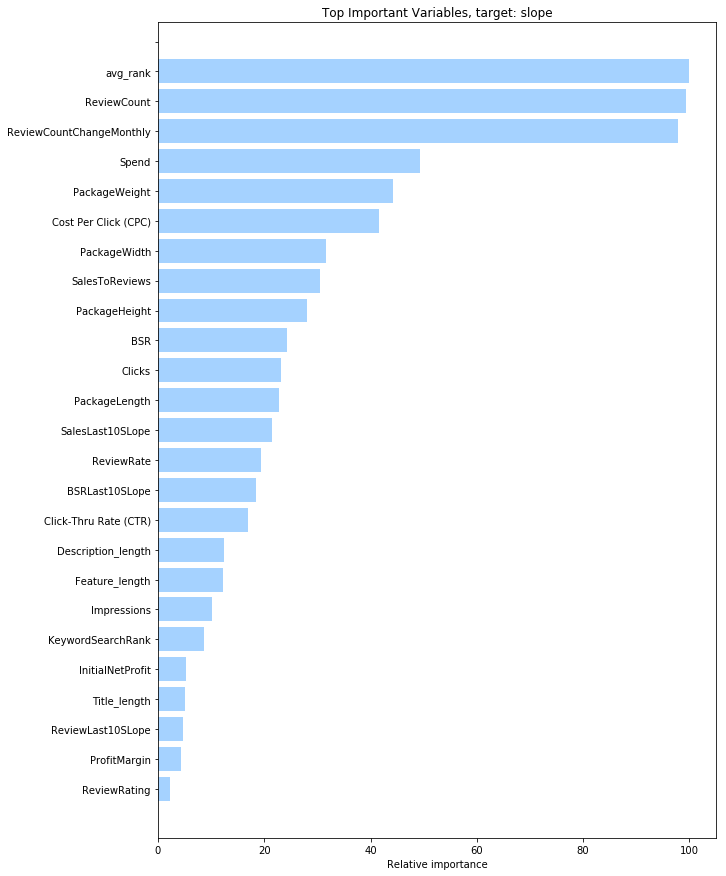

In [152]:
col_cpc, imp_cpc = rf_importance(target_v = 'slope', input_df=slp_cpc_sub, small_data=True, figure_size=(10,15))

In [164]:
# fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5, 20))
# for i in range(5):
#     var = ['Impressions', 'Clicks','Click-Thru Rate (CTR)', 'Cost Per Click (CPC)', 'Spend'][i]
#     plt.scatter(slp_cpc_sub[var], slp_cpc_sub['scaled_slope'])
#     plt.xlabel(var)
#     plt.ylabel('Scaled Slope')
#     plt.show()

In [165]:
# fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5, 20))
# for i in range(5):
#     var = ['Impressions', 'Clicks','Click-Thru Rate (CTR)', 'Cost Per Click (CPC)', 'Spend'][i]
#     plt.scatter(slp_cpc_sub[var], slp_cpc_sub['slope'])
#     plt.xlabel(var)
#     plt.ylabel('Slope')
#     plt.show()

In [166]:
# # Calculate the absolute errors
# errors = abs(rf_y - test_y)
# # Calculate mean absolute percentage error (MAPE)
# mape = 100 * (errors / test_y)
# # Calculate and display accuracy
# accuracy = 100 - np.mean(mape)

# # rf_acc_tr=accuracy_score(train_y, rf_tr)
# # rf_acc=accuracy_score(test_y, rf_y)

# # print("Random Forest model Accuracy for train set: {:.2f}%".format(rf_acc_tr*100))
# print("Random Forest model Accuracy for test set: {:.2f}%".format(accuracy))

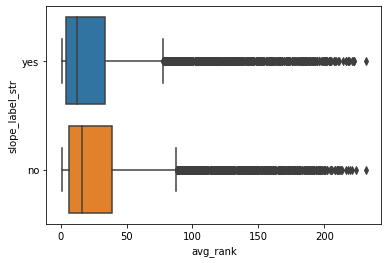

In [558]:
col = 'slope_label'
col_str = col+'_str'
pure_df[col_str] = pure_df[col].apply(lambda x:'yes' if x == 1 else 'no' )
sns.boxplot(y=col_str, x='avg_rank', data=pure_df, order=['yes', 'no'])

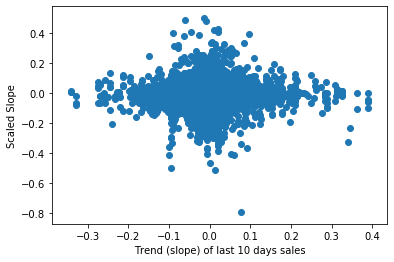

In [548]:
plt.scatter(pure_df['SalesLast10SLope'], pure_df['scaled_slope'])
plt.xlabel('Trend (slope) of last 10 days sales')
plt.ylabel('Scaled Slope')
plt.show()

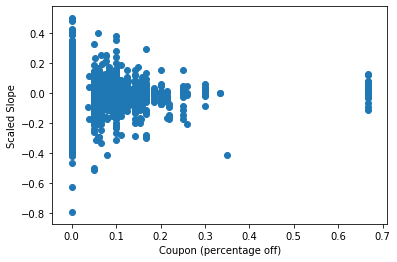

In [449]:
plt.scatter(test_df['CouponPercent'], test_df['scaled_slope'])
plt.xlabel('Coupon (percentage off)')
plt.ylabel('Scaled Slope')
plt.show()

/opt/tljh/user/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/tljh/user/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


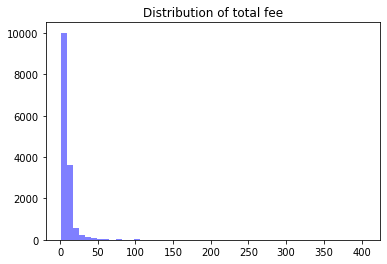

In [468]:
n, bins, patches = plt.hist(pure_df['Total_fee'], 50, facecolor='blue', alpha=0.5)
plt.title('Distribution of total fee')
plt.show()

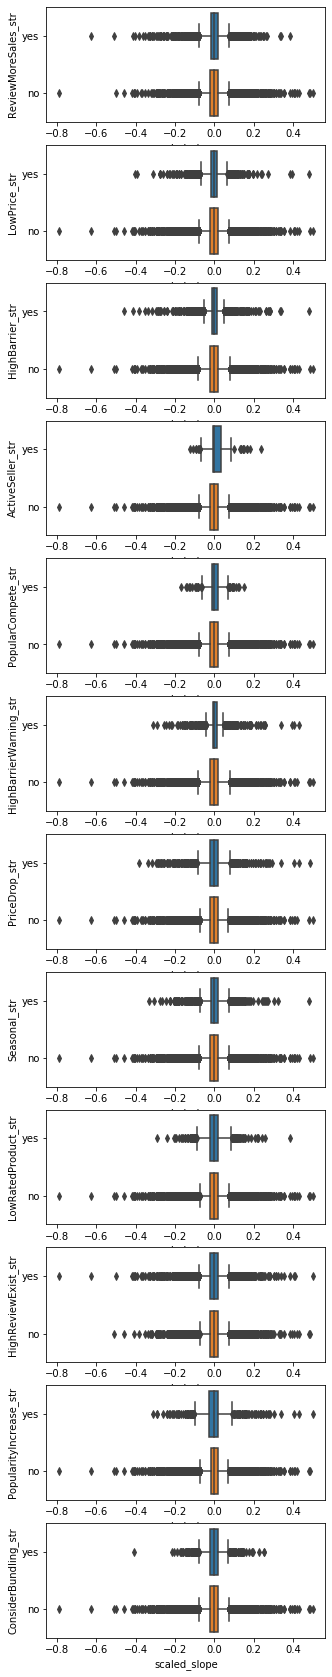

In [343]:
fig, axs = plt.subplots(nrows=12, ncols=1, figsize=(5, 30))
for i in range(12):
    col = ['ReviewMoreSales', 'LowPrice', 'HighBarrier', 'ActiveSeller', 'PopularCompete', 'HighBarrierWarning', 'PriceDrop', 
           'Seasonal', 'LowRatedProduct','HighReviewExist', 'PopularityIncrease','ConsiderBundling'][i]
    col_str = col+'_str'
    test_df[col_str] = test_df[col].apply(lambda x:'yes' if x == 1 else 'no' )
    sns.boxplot(y=col_str, x='scaled_slope', data=test_df, ax=axs[i], order=['yes', 'no'])


## Change of features for good campaign and bad campaign
### Compare the difference between good and bad, or compare the difference for one asin at the beginning and end of campaign

In [156]:
slp_thresh = 10 ### Only subset the part that the slope of campaign is very positive or very negative (using this threshold)
good_camp = pure_df[pure_df['slope']<-slp_thresh]
bad_camp = pure_df[pure_df['slope']>slp_thresh]
print(good_camp.shape)
print(bad_camp.shape)

(91, 69)
(113, 69)


In [262]:
def find_col_avg(input_df, not_needed=['slope', 'scaled_slope', 'slope_label']): # find the average value of a column
    avg_dicts = {}
    for col in input_df.columns:
        if col not in not_needed:
            avg_dicts[col] = input_df[col].mean()
    avg_df = pd.DataFrame({'col_name': list(avg_dicts.keys()),
                          'avg': list(avg_dicts.values())})
    avg_df = avg_df.sort_values(by = ['avg'], ascending = False)
    avg_df = avg_df.dropna()
    return avg_df
def find_change_ratio(x1, x2): # find the relative change of x2 over x1
    if np.isnan(x1)|np.isnan(x2):
        if np.isnan(x1) & np.isnan(x2):
            return np.NaN # 0 or np.NaN?
        else:
            return np.NaN
    elif x1 == 0:
        if x2 == 0:
            return 0
        else:
            return 1 # 1 or np.NaN
    else:
        return (x2-x1)/x1
    
def col_change_ratio(c1, c2): # c1 and c2 should be equal length list/arrays
    out_ls = []
    for i in range(len(c1)):
        x1 = c1[i]
        x2 = c2[i]
        out_ls.append(find_change_ratio(x1, x2))
    return out_ls


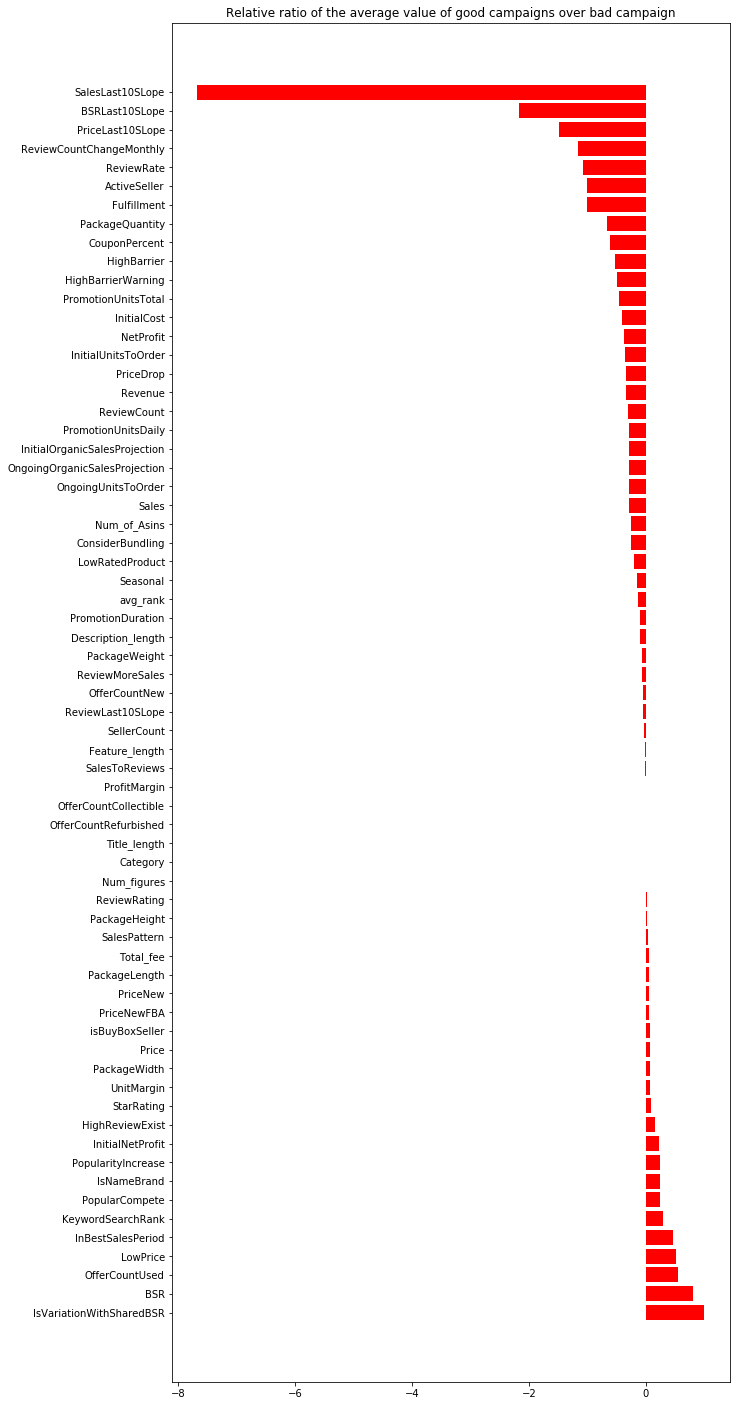

In [176]:
### compare the difference of column average between good campaign and bad campaign at the beginning of the campaign 
good_camp_avg = find_col_avg(good_camp)
good_camp_avg.columns = ['col_name', 'avg_good']
bad_camp_avg = find_col_avg(bad_camp)
bad_camp_avg.columns = ['col_name', 'avg_bad']
avg_merge = pd.merge(good_camp_avg, bad_camp_avg, on='col_name', how='left')
avg_merge['change_ratio'] = col_change_ratio(avg_merge['avg_bad'], avg_merge['avg_good'])
avg_merge = avg_merge.sort_values(by = ['change_ratio'], ascending = False)
plt.figure(figsize=(10,25))
bars = avg_merge['col_name']
y_pos = np.arange(len(bars))
plt.barh(y_pos, avg_merge['change_ratio'], color= 'red')
plt.yticks(y_pos, bars)
plt.title('Relative ratio of the average value of good campaigns over bad campaign')
plt.show()

In [260]:
avg_merge.to_csv('good_vs_bad_campaign.csv', index=False)
avg_merge.T

,57,1,46,44,47,0,56,55,48,9,41,33,22,29,19,40,20,21,25,26,37,34,31,17,24,15,63,64,18,30,5,38,59,36,43,35,6,27,16,45,50,52,28,11,7,8,12,23,13,2,49,10,3,4,14,51,53,58,42,62,61,32,39,60,65,54
col_name,IsVariationWithSharedBSR,BSR,OfferCountUsed,LowPrice,InBestSalesPeriod,KeywordSearchRank,PopularCompete,IsNameBrand,PopularityIncrease,InitialNetProfit,HighReviewExist,StarRating,UnitMargin,PackageWidth,Price,isBuyBoxSeller,PriceNewFBA,PriceNew,PackageLength,Total_fee,SalesPattern,PackageHeight,ReviewRating,Num_figures,Category,Title_length,OfferCountRefurbished,OfferCountCollectible,ProfitMargin,SalesToReviews,Feature_length,SellerCount,ReviewLast10SLope,OfferCountNew,ReviewMoreSales,PackageWeight,Description_length,PromotionDuration,avg_rank,Seasonal,LowRatedProduct,ConsiderBundling,Num_of_Asins,Sales,OngoingUnitsToOrder,OngoingOrganicSalesProjection,InitialOrganicSalesProjection,PromotionUnitsDaily,ReviewCount,Revenue,PriceDrop,InitialUnitsToOrder,NetProfit,InitialCost,PromotionUnitsTotal,HighBarrierWarning,HighBarrier,CouponPercent,PackageQuantity,Fulfillment,ActiveSeller,ReviewRate,ReviewCountChangeMonthly,PriceLast10SLope,BSRLast10SLope,SalesLast10SLope
avg_good,0.010989,91651.6,0.164835,0.186813,0.142857,1.96624e+06,0.010989,0.010989,0.131868,602.982,0.472527,2.80769,15.2843,6.54148,23.5479,0.967033,23.5478,23.336,10.7666,8.26363,1.48352,2.69101,4.33187,94.978,11.4725,157.769,0,0,60.9986,5.52901,1116.2,1.43956,0.00304924,1.49451,0.274725,1.63188,1115.66,8.02198,108.303,0.164835,0.0989011,0.032967,7.51648,350.242,875.582,875.582,315.209,11.6484,219.099,6152.82,0.120879,479.264,3771.81,2017.75,164.055,0.043956,0.032967,0.006533,0.340659,0,0,2.91154,1.35055,0.000307399,-0.00436313,0.0137242
avg_bad,0,50974.4,0.106195,0.123894,0.0973451,1.51482e+06,0.00884956,0.00884956,0.106195,491.381,0.40708,2.5708,14.2727,6.16089,22.19,0.911504,22.2163,22.0256,10.2407,7.91726,1.43363,2.64581,4.28761,94.115,11.4248,157.283,0,0,61.4459,5.57761,1140.7,1.47788,0.00320013,1.57522,0.292035,1.76637,1241.84,8.99115,125.981,0.19469,0.123894,0.0442478,10.1062,493.779,1234.44,1234.44,444.407,16.4425,316.442,9410.54,0.185841,753.584,5993.85,3463.53,309.177,0.0884956,0.0707965,0.0167345,1.00885,0.0176991,0.0176991,-42.0725,-8.70044,-0.000625097,0.00374918,-0.0020572
change_ratio,1,0.797991,0.552198,0.507849,0.467532,0.298,0.241758,0.241758,0.241758,0.227116,0.160774,0.0921488,0.0708723,0.0617757,0.0611948,0.0609197,0.0599344,0.0594976,0.0513525,0.0437487,0.0347985,0.017087,0.0103222,0.00916939,0.0041794,0.00309025,0,0,-0.00728051,-0.00871334,-0.0214792,-0.0259262,-0.0471516,-0.0512409,-0.0592741,-0.0761393,-0.101608,-0.107792,-0.140326,-0.153347,-0.201727,-0.254945,-0.25625,-0.290691,-0.290706,-0.290706,-0.290721,-0.29157,-0.307619,-0.346177,-0.349555,-0.364021,-0.37072,-0.417428,-0.469382,-0.503297,-0.534341,-0.60961,-0.662329,-1,-1,-1.0692,-1.15523,-1.49176,-2.16376,-7.67129


In [200]:
### find those negative ReviewRate, Amazon removes fake reviews, which may be the reason for sudden rank change
print('bad campaigns')
print(bad_camp[bad_camp['ReviewRate']<0][['slope','ReviewRate']].T)
print('-----------------------')
print('good campaigns')
print(good_camp[good_camp['ReviewRate']<0][['slope','ReviewRate']].T)

bad campaigns
                2941       2942    5364       5369       5386       5400   \
slope       11.321573  10.360215  34.775  13.350649  10.518519  11.363636   
ReviewRate -13.850000  -9.650000 -43.190 -43.190000 -43.190000 -43.190000   

                5720       7584       8017   9770         11464      15362  
slope       10.136646  19.346154  15.714286  11.25    13.361111  10.734375  
ReviewRate -99.020000  -7.670000 -11.230000 -20.64 -5000.000000  -6.780000  
-----------------------
good campaigns
                 2925        5706       5861   7658       8527       9212
slope      -13.944099  -18.615385 -11.729927 -20.70 -36.674419 -17.034884
ReviewRate -29.120000 -102.290000 -97.950000  -3.63  -7.410000 -78.800000


### The difference at the beginning and end of campaign for numeric values

In [242]:
v_counts = pure_df.nunique()
v_counts = v_counts[v_counts>=3]
numer_cols = list(v_counts.index)
numer_cols = [x for x in numer_cols if x not in ['Category', 'SalesPattern', 'slope', 'scaled_slope', 'avg_rank', 
                                                 'Num_of_Asins', 'KeywordSearchRank', 'BSRLast10SLope','PriceLast10SLope',
                                                 'ReviewLast10SLope','SalesLast10SLope','PackageHeight','PackageLength',
                                                 'PackageQuantity','PackageWeight','PackageWidth']]

In [215]:
process_cols2 = ['Description', 'Features', 'Fees', 'ImageUrls','Title',
                 'BSRDailyAverages','PriceDailyAverages', 'ReviewCountDailyAverages','SalesDailyAverages','Coupons']
start_df = new_features(start_asin_df, cols=process_cols2)
end_df = new_features(end_asin_df, cols=process_cols2)
start_df[['OfferCountNew', 'OfferCountUsed','OfferCountRefurbished','OfferCountCollectible']] = start_df[['OfferCountNew', 'OfferCountUsed','OfferCountRefurbished','OfferCountCollectible']].fillna(value=0)
end_df[['OfferCountNew', 'OfferCountUsed','OfferCountRefurbished','OfferCountCollectible']] = end_df[['OfferCountNew', 'OfferCountUsed','OfferCountRefurbished','OfferCountCollectible']].fillna(value=0)

In [282]:
slp_thresh = 10
good_camp = pure_slope_df[pure_slope_df['slope']<-slp_thresh]
bad_camp = pure_slope_df[pure_slope_df['slope']>slp_thresh]
print(good_camp.shape)
print(bad_camp.shape)

(312, 15)
(225, 15)


In [283]:
input_df =  good_camp

needed_cols = numer_cols.copy()
needed_cols.append('row_id')

orig_cols = list(input_df.columns)

start_sub = start_df[needed_cols]
start_colnames = ['start_' + x if x!='row_id' else x for x in start_sub.columns]
start_sub.columns = start_colnames

end_sub = end_df[needed_cols]
end_colnames = ['end_' + x if x!='row_id' else x for x in end_sub.columns]
end_sub.columns = end_colnames

input_df = pd.merge(input_df, start_sub, on='row_id', how='left')
input_df = pd.merge(input_df, end_sub, on='row_id', how='left')

needed_cols2 = [x for x in needed_cols if x!= 'row_id']

for col in needed_cols2:
    start_col = 'start_' + col
    end_col = 'end_' + col
    input_df[col] = col_change_ratio(input_df[start_col], input_df[end_col])

final_cols = orig_cols + needed_cols2

input_df = input_df[final_cols]

print(input_df.info())

avg_df = find_col_avg(input_df[numer_cols])
# plt.figure(figsize=(10,20))
# bars = avg_df['col_name']
# y_pos = np.arange(len(bars))
# plt.barh(y_pos, avg_df['avg'])
# plt.yticks(y_pos, bars)
# plt.title('Relative change from the begining to the end of the good campaign')
# plt.show()

y_pos_good = y_pos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 311
Data columns (total 48 columns):
campaign_dates                   312 non-null object
keyword                          312 non-null object
num_ads                          312 non-null object
parent_asin                      312 non-null object
rank_dates                       312 non-null object
ranks                            312 non-null object
record_asin                      312 non-null object
seller                           312 non-null object
slope                            312 non-null float64
variation_asins                  312 non-null object
vt_purity                        312 non-null float64
avg_rank                         312 non-null float64
row_id                           312 non-null int64
most_common_asin                 312 non-null object
scaled_slope                     312 non-null float64
Description_length               115 non-null float64
Feature_length                   115 non-nu

In [284]:
input_df =  bad_camp

needed_cols = numer_cols.copy()
needed_cols.append('row_id')

orig_cols = list(input_df.columns)

start_sub = start_df[needed_cols]
start_colnames = ['start_' + x if x!='row_id' else x for x in start_sub.columns]
start_sub.columns = start_colnames

end_sub = end_df[needed_cols]
end_colnames = ['end_' + x if x!='row_id' else x for x in end_sub.columns]
end_sub.columns = end_colnames

input_df = pd.merge(input_df, start_sub, on='row_id', how='left')
input_df = pd.merge(input_df, end_sub, on='row_id', how='left')

needed_cols2 = [x for x in needed_cols if x!= 'row_id']

for col in needed_cols2:
    start_col = 'start_' + col
    end_col = 'end_' + col
    input_df[col] = col_change_ratio(input_df[start_col], input_df[end_col])

final_cols = orig_cols + needed_cols2

input_df = input_df[final_cols]

print(input_df.info())

avg_df2 = find_col_avg(input_df[numer_cols])
# plt.figure(figsize=(10,20))
# bars = avg_df['col_name']
# # y_pos = np.arange(len(bars))
# plt.barh(y_pos_good, avg_df['avg'], color='green')
# plt.yticks(y_pos_good, bars)
# plt.title('Relative change from the begining to the end of the bad campaign')
# plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 0 to 224
Data columns (total 48 columns):
campaign_dates                   225 non-null object
keyword                          225 non-null object
num_ads                          225 non-null object
parent_asin                      225 non-null object
rank_dates                       225 non-null object
ranks                            225 non-null object
record_asin                      225 non-null object
seller                           225 non-null object
slope                            225 non-null float64
variation_asins                  225 non-null object
vt_purity                        225 non-null float64
avg_rank                         225 non-null float64
row_id                           225 non-null int64
most_common_asin                 225 non-null object
scaled_slope                     225 non-null float64
Description_length               125 non-null float64
Feature_length                   125 non-nu

In [285]:
avg_df.columns = ['col_name', 'good']
avg_df2.columns = ['col_name', 'bad']
avg_df = pd.merge(avg_df, avg_df2, on='col_name', how='left')

Text(0, 0.5, '')

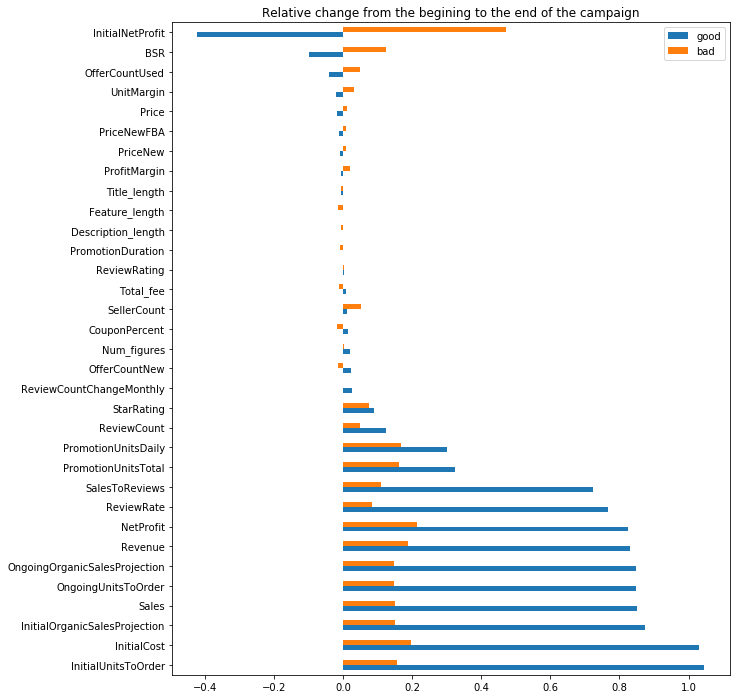

In [286]:
ax = avg_df.plot(x='col_name', y=['good', 'bad'], kind='barh', figsize=(10,12), title='Relative change from the begining to the end of the campaign')
ax.set_ylabel(None)

In [124]:
needed_cols = ['BSR', 'NetProfit', 'OfferCountNew', 'OfferCountUsed', 'PackageHeight', 'PackageLength', 'PackageQuantity', 
               'PackageWeight', 'PackageWidth', 'Price', 'PriceNew', 'PriceNewFBA', 'ProfitMargin', 'Revenue', 'ReviewCount', 
               'ReviewRate', 'ReviewRating', 'Sales', 'SalesLastYear', 'SalesToReviews', 'SellerCount', 'UnitMargin', 
               'StarRating', 'PriceChangeLastNinetyDays', 'ReviewCountChangeMonthly', 'SalesChangeLastNinetyDays', 
               'SalesYearOverYear', 'InitialCost', 'InitialNetProfit', 'InitialOrganicSalesProjection', 'InitialUnitsToOrder', 
               'OngoingOrganicSalesProjection', 'OngoingUnitsToOrder', 'PromotionDuration', 'PromotionUnitsDaily', 
               'PromotionUnitsTotal', 'row_id', 'OfferCountRefurbished', 'OfferCountCollectible']

input_df =  good_camp
orig_cols = list(input_df.columns)

start_sub = start_asin_df[needed_cols]
start_colnames = ['start_' + x if x!='row_id' else x for x in start_sub.columns]
start_sub.columns = start_colnames

end_sub = end_asin_df[needed_cols]
end_colnames = ['end_' + x if x!='row_id' else x for x in end_sub.columns]
end_sub.columns = end_colnames

input_df = pd.merge(input_df, start_sub, on='row_id', how='left')
input_df = pd.merge(input_df, end_sub, on='row_id', how='left')

needed_cols2 = [x for x in needed_cols if x!= 'row_id']

for col in needed_cols2:
    start_col = 'start_' + col
    end_col = 'end_' + col
    input_df[col] = col_change_ratio(input_df[start_col], input_df[end_col])

final_cols = orig_cols + needed_cols2

input_df = input_df[final_cols]

input_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 123
Data columns (total 52 columns):
campaign_dates                   124 non-null object
keyword                          124 non-null object
num_ads                          124 non-null object
parent_asin                      124 non-null object
rank_dates                       124 non-null object
ranks                            124 non-null object
record_asin                      124 non-null object
seller                           124 non-null object
slope                            124 non-null float64
variation_asins                  124 non-null object
vt_purity                        124 non-null float64
avg_rank                         124 non-null float64
row_id                           124 non-null int64
most_common_asin                 124 non-null object
BSR                              45 non-null float64
NetProfit                        44 non-null float64
OfferCountNew                    46 non-null 

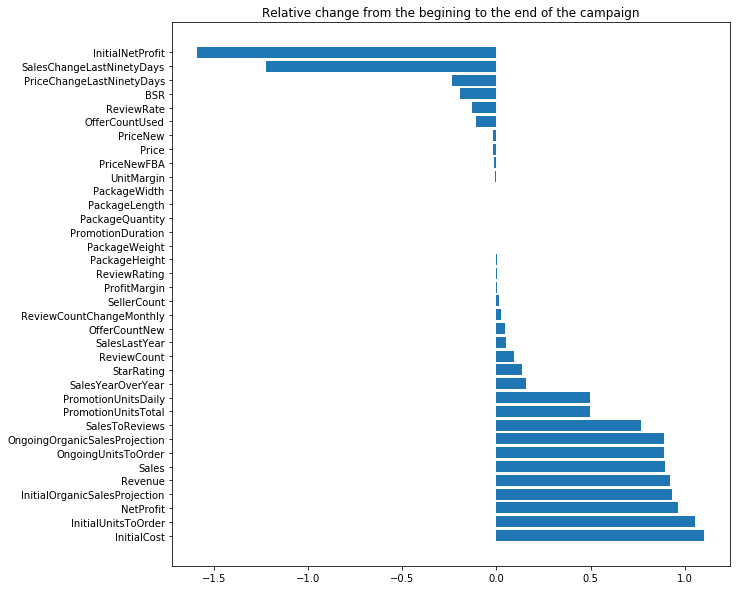

In [371]:
### this figure is only for the good campaigns
plt.figure(figsize=(10,10))
bars = avg_df['col_name']
y_pos = np.arange(len(bars))
plt.barh(y_pos, avg_df['avg'])
plt.yticks(y_pos, bars)
plt.title('Relative change from the begining to the end of the campaign')
plt.show()

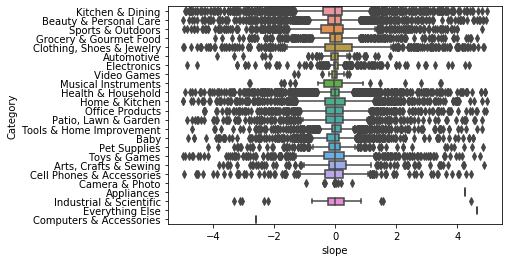

In [148]:
########### boxplot of the slopes vs catergory of the products
sns.boxplot(y='Category', x='slope', data=pure_slp_merge[abs(pure_slp_merge['slope'])<=5])

In [281]:
pure_slope_df = pure_slope_df.sort_values(by = ['slope'], ascending = False)
pure_slope_df.head(10)

,campaign_dates,keyword,num_ads,parent_asin,rank_dates,ranks,record_asin,seller,slope,variation_asins,vt_purity,avg_rank,row_id,most_common_asin,scaled_slope
12844,"[2019-04-17, 2019-04-18, 2019-04-19, 2019-04-2...",nurse badge reference cards,"[2, 0, 28, 16, 40]",B07J17Z3W6,"[2019-04-19, 2019-04-20, 2019-04-22, 2019-04-2...","[1, 1, 196, 205, 213]","[B07J17Z3W6, B07J17Z3W6, B07J17Z3W6, B07J17Z3W...",A28Z0B0VE3VH3V,52.000000,[B07J17Z3W6],1.0,123.200000,12844,B07J17Z3W6,0.422078
44304,"[2019-04-14, 2019-04-15, 2019-04-17, 2019-04-1...",cutting board,"[4, 20, 28, 28, 32]",B07G4VFF52,"[2019-04-26, 2019-04-27, 2019-04-28, 2019-04-2...","[67, 75, 109, 148, 184]","[B07BJ691T4, B07BJ691T4, B07BJ691T4, B07BJ691T...",AEATJJJ6Z6H87,37.852941,"[B07BVQYH67, B07BVSFPBP, B07BSKQJJH, B07BSNXS3...",1.0,116.600000,44304,B07BJ691T4,0.324639
15786,"[2019-06-07, 2019-06-08, 2019-06-09, 2019-06-1...",vitamin c serum,"[12.0, 24.0, 22.0, 18.0, 34.0, 44.0]",B07R4455P9,"[2019-06-07, 2019-06-08, 2019-06-09, 2019-06-1...","[65.0, 63.0, 64.0, 63.0, 139.0, 220.0]","[B01B5G45R6, B01B5G45R6, B01B5G45R6, B01B5G45R...",A3J3NRHRCQ8K5E,34.775000,"[B0184QI2EC, B01B5G45R6, B0118B8UXI, B01412ZUD...",1.0,102.333333,15786,B01B5G45R6,0.339821
11510,"[2019-05-14, 2019-05-15, 2019-05-16, 2019-05-1...",chips set,"[16, 8, 20, 44, 40]",B001M9HM18,"[2019-05-16, 2019-05-17, 2019-05-18, 2019-05-1...","[57, 73, 122, 163, 160]","[B001M9HM18, B001M9HM18, B001M9HM18, B001M9HM1...",A2L0LODUJGR5H7,34.027778,[B001M9HM18],1.0,115.000000,11510,B001M9HM18,0.295894
1454,"[2019-04-07, 2019-04-08, 2019-04-09, 2019-04-1...",dog seat cover,"[6, 6, 6, 32, 28]",B07QNZTJ56,"[2019-04-07, 2019-04-08, 2019-04-09, 2019-04-1...","[28, 30, 35, 144, 104]","[B07HCT72Z3, B07HCT72Z3, B07HCT72Z3, B07HCT72Z...",A20VIZX6VH86F4,33.205882,"[B07BCPZHH8, B07KG1RFK1, B07HCT72Z3, B07QNZTJ56]",1.0,68.200000,1454,B07HCT72Z3,0.486890
36924,"[2019-05-03, 2019-05-04, 2019-05-06, 2019-05-0...",bibs,"[20, 20, 20, 24, 28, 40, 44]",B07DQVP3FK,"[2019-05-03, 2019-05-04, 2019-05-05, 2019-05-0...","[81, 87, 83, 181, 160, 195, 239]","[B01A1AH0CO, B01A1AH0CO, B01A1AH0CO, B01A1AH0C...",A2DGY2Y99U9RBE,33.036765,"[B01A1AH0BA, B01A1AH0CO, B01F9LRQV0, B01N1M7YX...",1.0,146.571429,36924,B01A1AH0CO,0.225397
29518,"[2019-04-14, 2019-04-16, 2019-04-17, 2019-04-1...",coconut oil,"[20, 16, 16, 16, 32]",B078HCNF4C,"[2019-04-14, 2019-04-15, 2019-04-16, 2019-04-1...","[69, 64, 68, 61, 233]","[B00ODJDKWY, B00ODJDKWY, B00ODJDKWY, B00ODJDKW...",AZHG42YVCIQFR,32.732558,"[B078J8GT69, B00ODJDKWY, B078HCNF4C]",1.0,99.000000,29518,B00ODJDKWY,0.330632
11511,"[2019-05-14, 2019-05-15, 2019-05-16, 2019-05-1...",poker chip,"[20, 20, 20, 36, 44, 52]",B001M9HM18,"[2019-05-15, 2019-05-16, 2019-05-17, 2019-05-1...","[81, 84, 90, 162, 184, 198]","[B001M9HM18, B001M9HM18, B001M9HM18, B001M9HM1...",A2L0LODUJGR5H7,31.975000,[B001M9HM18],1.0,133.166667,11511,B001M9HM18,0.240113
11451,"[2019-05-14, 2019-05-16, 2019-05-18, 2019-05-1...",wooden cake,"[16, 20, 32, 20, 32]",B0771PN4YG,"[2019-05-18, 2019-05-19, 2019-05-20, 2019-05-2...","[62, 66, 128, 94, 237]","[B0771PN4YG, B0771PN4YG, B0771PN4YG, B0771PN4Y...",A2L0LODUJGR5H7,31.727273,[B0771PN4YG],1.0,117.400000,11451,B0771PN4YG,0.270249
25008,"[2019-06-05, 2019-06-06, 2019-06-07, 2019-06-0...",name tags,"[20, 22, 32, 44, 56]",B07LHHB4X1,"[2019-06-05, 2019-06-06, 2019-06-07, 2019-06-0...","[77, 134, 169, 162, 236]","[B07LHHB4X1, B07LHHB4X1, B07LHHB4X1, B07LHHB4X...",A1NCT4T3XD70AR,31.053571,[B07LHHB4X1],1.0,155.600000,25008,B07LHHB4X1,0.199573


## ---------------------------------------------------------------------------------------------------------------------------------
## **
## **
## ONLY ACTIONABLE VARIABLES
### At this stage, maybe we can pay attention to the choice of keywords and change of price
## **
## **
## ---------------------------------------------------------------------------------------------------------------------------------

In [ ]:
action_features = ['isBuyBoxSeller', 'Description_length', 'Feature_length',
                   'Total_fee', 'Fulfillment', 'Num_figures', 'IsVariationWithSharedBSR',
                   'Title_length', 'Num_of_Asins', 'LowPrice',
                   'HighBarrier', 'ActiveSeller', 'PopularCompete', 'HighBarrierWarning',
                   'PriceDrop', 'LowRatedProduct', 'HighReviewExist',
                   'PopularityIncrease', 'ConsiderBundling', 'InBestSalesPeriod',
                   'IsNameBrand', 'CouponPercent','KeywordSearchRank', 'slope', 'scaled_slope', 'avg_rank',
                   'PackageWeight', 
                   'Price', 'ProfitMargin', 
                   'SellerCount', 'UnitMargin',
                   'InitialCost', 'InitialNetProfit', 
                   'slope_label']

In [289]:
slp_thresh = 10
good_camp = pure_df[pure_df['slope']<-slp_thresh]
bad_camp = pure_df[pure_df['slope']>slp_thresh]
print(good_camp.shape)
print(bad_camp.shape)

(91, 69)
(113, 69)


In [95]:
#### looks like that a seller could do the campaigns for one ASIN for many keywords at the same time, here is one example
example_slp = pure_slope_df[pure_slope_df['most_common_asin']=='B078YCFZDB']
print(example_slp.shape)
example_slp.groupby('keyword').count()

(90, 16)


,campaign_dates,num_ads,parent_asin,rank_dates,ranks,record_asin,seller,slope,variation_asins,vt_purity,avg_rank,row_id,most_common_asin,scaled_slope,campaign_label
keyword,,,,,,,,,,,,,,,
blepharitis treatment,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
bruder eye mask,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
compress,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
dry eye mask,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
dry eye relief mask,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
dry eyes,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
eye mask for dry eyes,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
heyedrate,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
stye eye compress,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9


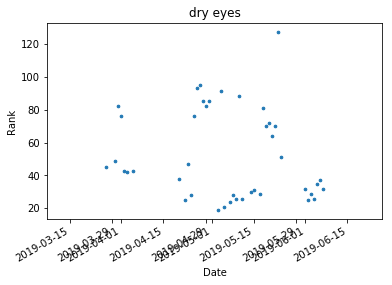

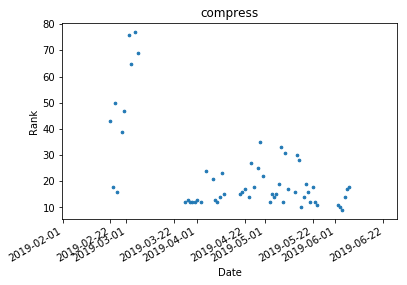

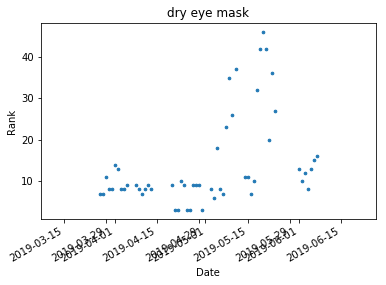

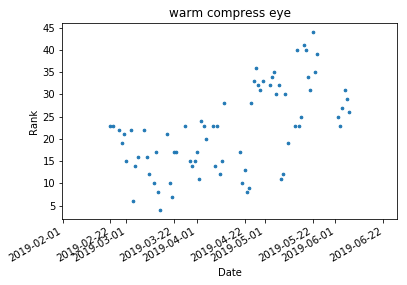

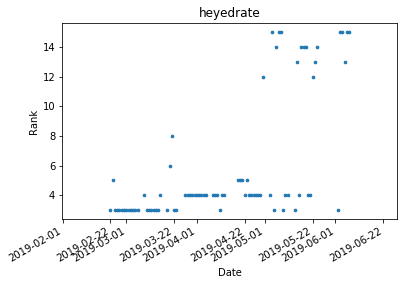

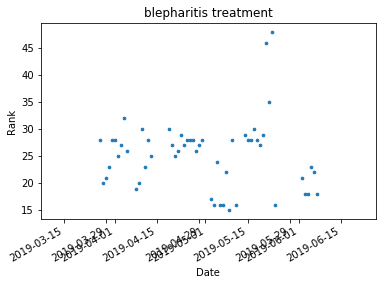

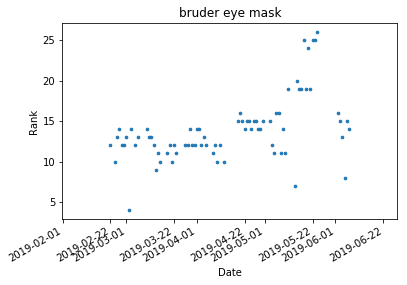

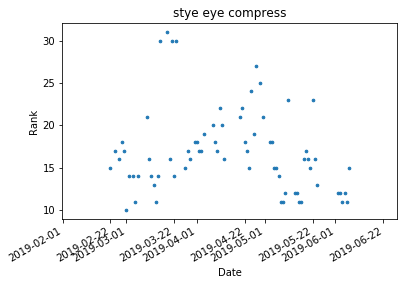

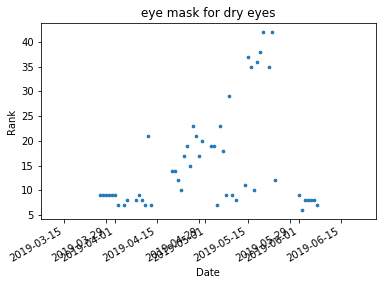

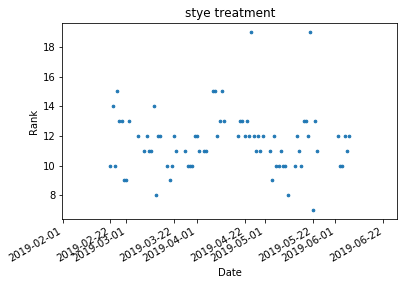

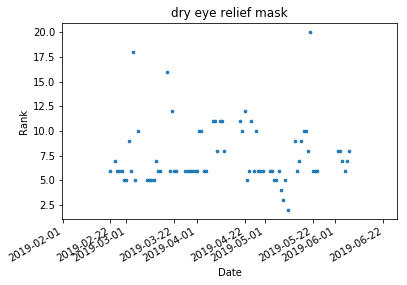

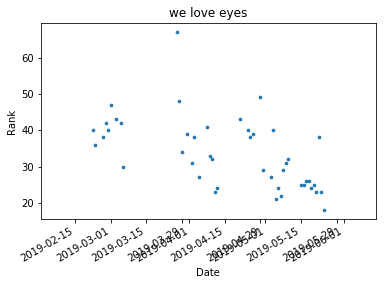

In [338]:
#### plot the rank of this ASIN regarding different keywords
for kw in list(example_slp['keyword'].unique()):
    example_slp_1w = example_slp[example_slp['keyword']==kw]
    date_list = []
    rank_list = []
    for i in range(len(example_slp_1w)):
        dates_i = example_slp_1w['rank_dates'].iloc[i]
        ranks_i = example_slp_1w['ranks'].iloc[i]
        date_list = date_list + dates_i
        rank_list = rank_list + ranks_i

    date_list = [pd.to_datetime(x) for x in date_list]
    plt.scatter(date_list, rank_list, s=7)
    plt.xlabel('Date')
    plt.ylabel('Rank')
    plt.title(kw)
    plt.gcf().autofmt_xdate()
    plt.show()

In [96]:
example_slp_1w = example_slp[example_slp['keyword']=='eye mask for dry eyes']

for i in range(len(example_slp_1w)):
    print(example_slp_1w['rank_dates'].iloc[i])
    print(example_slp_1w['ranks'].iloc[i])
    print('*************************************************')


#### I printed these out to check whether there are overlap or inconsistence in the data.

['2019-03-27', '2019-03-28', '2019-03-29', '2019-03-30', '2019-03-31', '2019-04-01', '2019-04-02', '2019-04-04', '2019-04-05']
[9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 7.0, 7.0, 8.0]
*************************************************
['2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13']
[8.0, 9.0, 8.0, 7.0, 21.0, 7.0]
*************************************************
['2019-04-20', '2019-04-21', '2019-04-22', '2019-04-23', '2019-04-24', '2019-04-25', '2019-04-26', '2019-04-27', '2019-04-28', '2019-04-29', '2019-04-30']
[14.0, 14.0, 12.0, 10.0, 17.0, 19.0, 15.0, 23.0, 21.0, 17.0, 20.0]
*************************************************
['2019-05-03', '2019-05-04', '2019-05-05', '2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09', '2019-05-10', '2019-05-11']
[19.0, 19.0, 7.0, 23.0, 18.0, 9.0, 29.0, 9.0, 8.0]
*************************************************
['2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17', '2019-05-18', '2019-05-19', '2019-05-20', '2019-05-22

## Get the information of the competitors

In [15]:
########### Calculate the price after applying the coupon
def price_after_coupon(row):
    p = row['Price']
    try:
        a = row['Coupons']
        c = a[0]
        if "%" in c:
            m = re.search('Save (.+?)%', c).group(1)
            p_output = (1-float(m)/100)*p
        elif "$" in c:
            m = re.search('\$(.+?) with', c).group(1)
            p_output = p - float(m)
        else:
            p_output = p
#         print('Price: {}, Coupon: {}, Price_with_coupon:{}'.format(p,c,p_output))
        return p_output
    except:
        return p

In [111]:
##### Compare the status of a asin with the competitors for a keyword
def compare_to_competitors(input_asin, keyword, target_date, num_of_competitors = 20, var_to_compare=['price_with_coupon', 'Sales', 'ReviewCount','ReviewRating']):
    from_date = pd.to_datetime(target_date)
    to_date =   pd.to_datetime(target_date)+ timedelta(days=1)
    selected_keyw = keyword
    with VTracker(secret=vt_key) as vt:
        try:
            df_vt = vt.GetVTrackerData(keywords=selected_keyw,
                               asins=[],
                               from_date=from_date,
                               to_date=to_date)
        except:
            df_vt = pd.DataFrame()
    if len(df_vt)>0:
        df_vt = df_vt.drop_duplicates(subset=['asin','rank', 'scrapeDate'])
        df_vt = df_vt.sort_values(['rank'], ascending=[True])
        pct_sponsor = df_vt['isSponsoredAd'].sum()/len(df_vt)
        top_asins = list(df_vt['asin'])[:num_of_competitors]
        info_tops = []
        for i in range(num_of_competitors):
            asin = top_asins[i]
            used_blob_name, used_dt = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=asin, pd_date=target_date)
            try:
                asin_data = blob.GetSpecificAsinData(used_blob_name)
                asin_data['price_with_coupon'] = price_after_coupon(asin_data)
                info_tops.append(asin_data)
            except:
                pass
        info_tops_df = merge_dicts_to_df(info_tops)
        used_blob_name_T, used_dt_T = blob.GetASIN_Closest_Blob_Names_By_Date(marketplace=marketplace, asin=input_asin, pd_date=target_date)
        asin_data_T = blob.GetSpecificAsinData(used_blob_name_T)
        asin_data_T['price_with_coupon'] = price_after_coupon(asin_data_T)
        compare_dict = {}
        for k in var_to_compare:
            target_v = asin_data_T[k]
            comp_avg = np.mean(info_tops_df[k])
            compare_dict[k] = target_v/comp_avg
        compare_dict['pct_sponsor'] = pct_sponsor
        compare_dict['Date'] = target_date
        compare_dict['num_of_comp'] = len(info_tops_df)
    else:
        compare_dict = {}
    return compare_dict
        

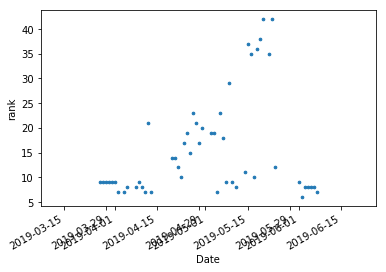

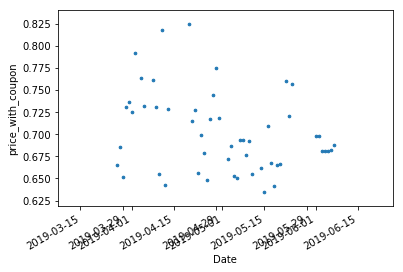

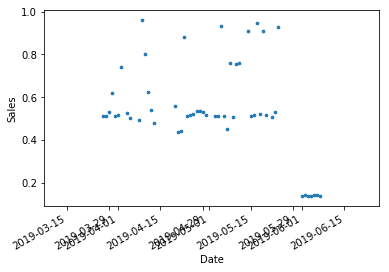

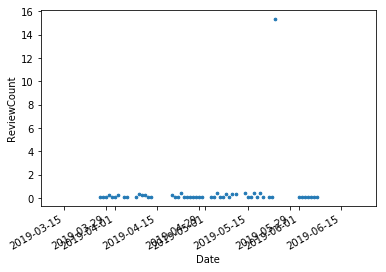

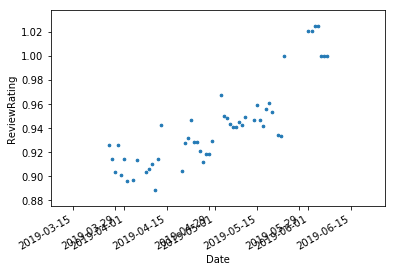

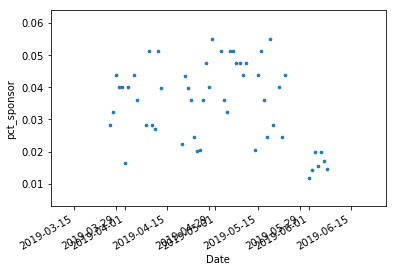

In [434]:
input_asin = 'B078YCFZDB'
kw = 'eye mask for dry eyes'
example_slp_1w = example_slp[example_slp['keyword']==kw]
date_list = []
rank_list = []
for i in range(len(example_slp_1w)):
    dates_i = example_slp_1w['rank_dates'].iloc[i]
    ranks_i = example_slp_1w['ranks'].iloc[i]
    date_list = date_list + dates_i
    rank_list = rank_list + ranks_i

comps_ls = []

for i in range(len(date_list)):
    d = date_list[i]
    r = rank_list[i]
    compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d)
    if 'price_with_coupon' in compare_dict.keys():
        compare_dict['rank'] = r
        comps_ls.append(compare_dict)
comps_df = merge_dicts_to_df(comps_ls)

date_list = list(comps_df['Date'])
date_list = [pd.to_datetime(x) for x in date_list]

for col in ['rank','price_with_coupon', 'Sales', 'ReviewCount', 'ReviewRating', 'pct_sponsor']:
    v_list = comps_df[col]
    plt.scatter(date_list, v_list, s=7)
    plt.xlabel('Date')
    plt.ylabel(col)
#     plt.title(kw)
    plt.gcf().autofmt_xdate()
    plt.show()

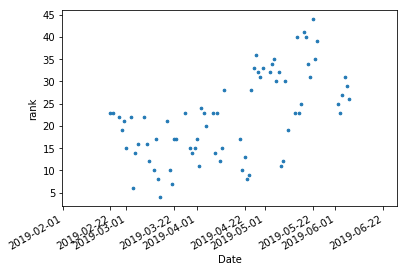

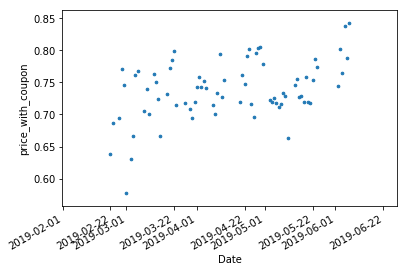

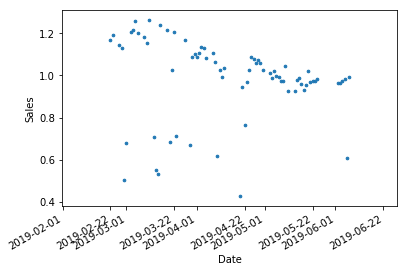

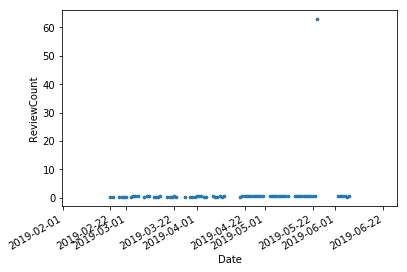

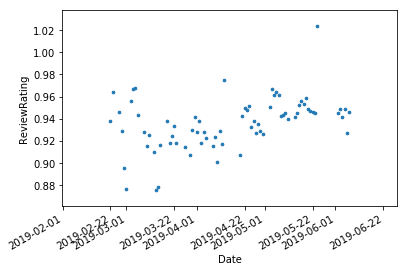

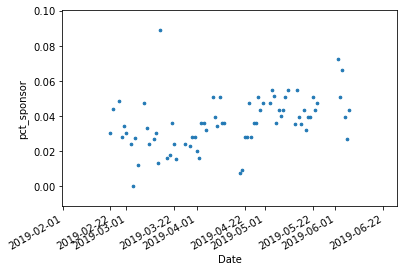

In [97]:
input_asin = 'B078YCFZDB'
kw = 'warm compress eye'
example_slp_1w = example_slp[example_slp['keyword']==kw]
date_list = []
rank_list = []
for i in range(len(example_slp_1w)):
    dates_i = example_slp_1w['rank_dates'].iloc[i]
    ranks_i = example_slp_1w['ranks'].iloc[i]
    date_list = date_list + dates_i
    rank_list = rank_list + ranks_i

comps_ls = []

for i in range(len(date_list)):
    d = date_list[i]
    r = rank_list[i]
    compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d)
    if 'price_with_coupon' in compare_dict.keys():
        compare_dict['rank'] = r
        comps_ls.append(compare_dict)
comps_df = merge_dicts_to_df(comps_ls)

date_list = list(comps_df['Date'])
date_list = [pd.to_datetime(x) for x in date_list]

for col in ['rank','price_with_coupon', 'Sales', 'ReviewCount', 'ReviewRating', 'pct_sponsor']:
    v_list = comps_df[col]
    plt.scatter(date_list, v_list, s=7)
    plt.xlabel('Date')
    plt.ylabel(col)
#     plt.title(kw)
    plt.gcf().autofmt_xdate()
    plt.show()

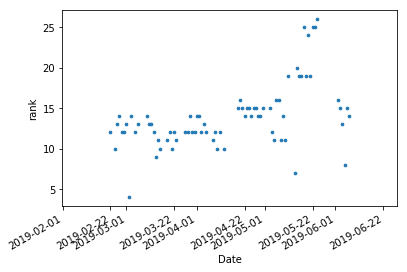

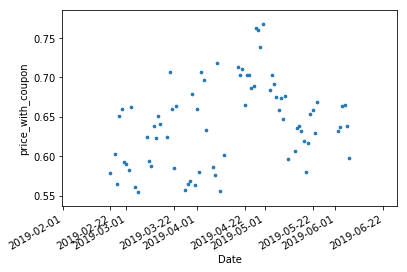

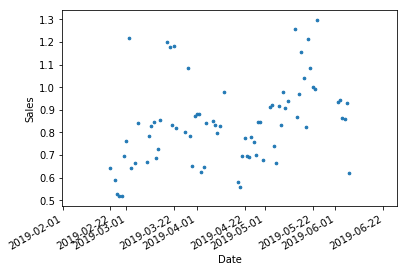

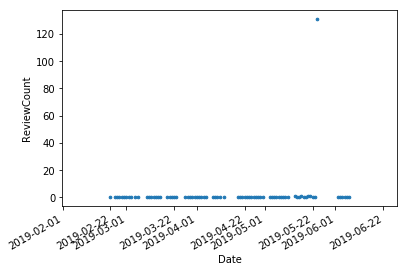

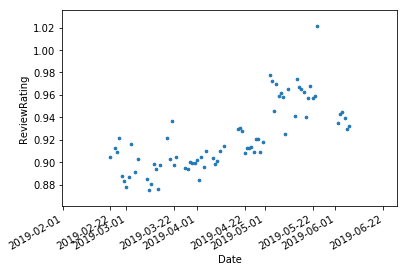

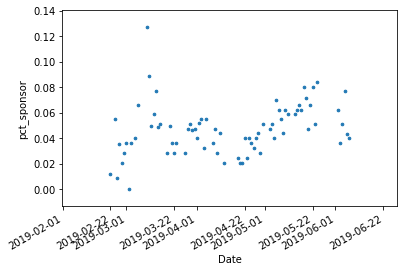

In [112]:
input_asin = 'B078YCFZDB'
kw = 'bruder eye mask'
example_slp_1w = example_slp[example_slp['keyword']==kw]
date_list = []
rank_list = []
for i in range(len(example_slp_1w)):
    dates_i = example_slp_1w['rank_dates'].iloc[i]
    ranks_i = example_slp_1w['ranks'].iloc[i]
    date_list = date_list + dates_i
    rank_list = rank_list + ranks_i

comps_ls = []

for i in range(len(date_list)):
    d = date_list[i]
    r = rank_list[i]
    compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d)
    if 'price_with_coupon' in compare_dict.keys():
        compare_dict['rank'] = r
        comps_ls.append(compare_dict)
comps_df = merge_dicts_to_df(comps_ls)

date_list = list(comps_df['Date'])
date_list = [pd.to_datetime(x) for x in date_list]

for col in ['rank','price_with_coupon', 'Sales', 'ReviewCount', 'ReviewRating', 'pct_sponsor']:
    v_list = comps_df[col]
    plt.scatter(date_list, v_list, s=7)
    plt.xlabel('Date')
    plt.ylabel(col)
#     plt.title(kw)
    plt.gcf().autofmt_xdate()
    plt.show()


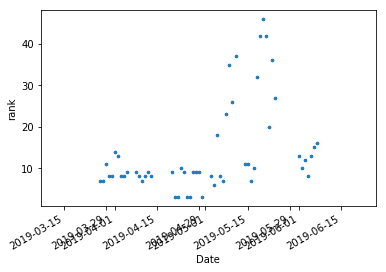

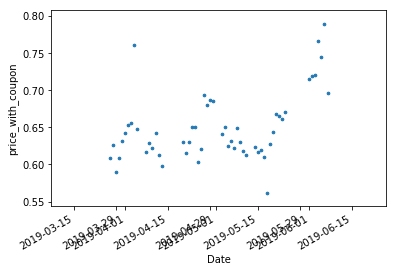

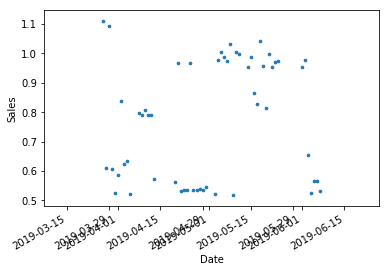

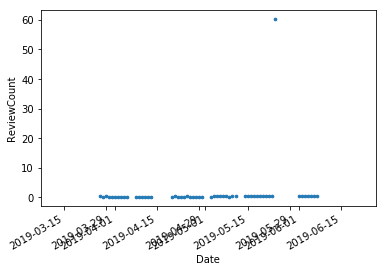

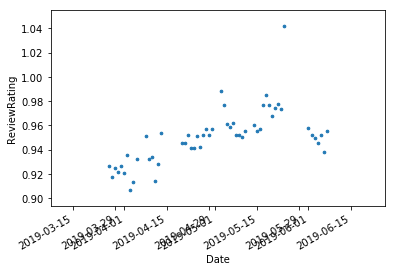

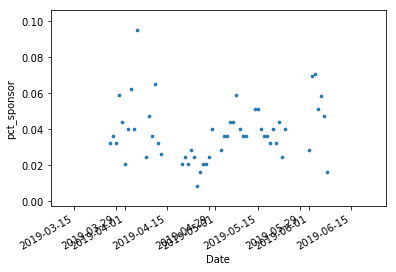

In [121]:
input_asin = 'B078YCFZDB'
kw = 'dry eye mask'
example_slp_1w = example_slp[example_slp['keyword']==kw]
date_list = []
rank_list = []
for i in range(len(example_slp_1w)):
    dates_i = example_slp_1w['rank_dates'].iloc[i]
    ranks_i = example_slp_1w['ranks'].iloc[i]
    date_list = date_list + dates_i
    rank_list = rank_list + ranks_i

comps_ls = []

for i in range(len(date_list)):
    d = date_list[i]
    r = rank_list[i]
    compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d)
    if 'price_with_coupon' in compare_dict.keys():
        compare_dict['rank'] = r
        comps_ls.append(compare_dict)
comps_df = merge_dicts_to_df(comps_ls)

date_list = list(comps_df['Date'])
date_list = [pd.to_datetime(x) for x in date_list]

for col in ['rank','price_with_coupon', 'Sales', 'ReviewCount', 'ReviewRating', 'pct_sponsor']:
    v_list = comps_df[col]
    plt.scatter(date_list, v_list, s=7)
    plt.xlabel('Date')
    plt.ylabel(col)
#     plt.title(kw)
    plt.gcf().autofmt_xdate()
    plt.show()


In [122]:
############### plot the change of rank and competition over time for a asin and keyword
def plot_competition(input_asin, kw): 
    example_slp = pure_slope_df[pure_slope_df['most_common_asin']==input_asin]
    example_slp_1w = example_slp[example_slp['keyword']==kw]
    date_list = []
    rank_list = []
    for i in range(len(example_slp_1w)):
        dates_i = example_slp_1w['rank_dates'].iloc[i]
        ranks_i = example_slp_1w['ranks'].iloc[i]
        date_list = date_list + dates_i
        rank_list = rank_list + ranks_i

    comps_ls = []

    for i in range(len(date_list)):
        d = date_list[i]
        r = rank_list[i]
        compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d)
        if 'price_with_coupon' in compare_dict.keys():
            compare_dict['rank'] = r
            comps_ls.append(compare_dict)
    comps_df = merge_dicts_to_df(comps_ls)

    date_list = list(comps_df['Date'])
    date_list = [pd.to_datetime(x) for x in date_list]

    for col in ['rank','price_with_coupon', 'Sales', 'ReviewCount', 'ReviewRating', 'pct_sponsor']:
        v_list = comps_df[col]
        plt.scatter(date_list, v_list, s=7)
        plt.xlabel('Date')
        plt.ylabel(col)
    #     plt.title(kw)
        plt.gcf().autofmt_xdate()
        plt.show()


In [145]:
############### plot the change of rank and competition over time for a asin and keyword
def plot_compet_price_vs_sale(input_asin, kw): 
    example_slp = pure_slope_df[pure_slope_df['most_common_asin']==input_asin]
    example_slp_1w = example_slp[example_slp['keyword']==kw]
    date_list = []
    rank_list = []
    for i in range(len(example_slp_1w)):
        dates_i = example_slp_1w['rank_dates'].iloc[i]
        ranks_i = example_slp_1w['ranks'].iloc[i]
        date_list = date_list + dates_i
        rank_list = rank_list + ranks_i

    comps_ls = []

    for i in range(len(date_list)):
        d = date_list[i]
        r = rank_list[i]
        compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d, var_to_compare=['price_with_coupon', 'Sales'])
        if 'price_with_coupon' in compare_dict.keys():
            compare_dict['rank'] = r
            comps_ls.append(compare_dict)
    comps_df = merge_dicts_to_df(comps_ls)
    
    plt.scatter(comps_df['price_with_coupon'], comps_df['Sales'], s=7)
    plt.xlabel('Price with coupon compared to competitors')
    plt.ylabel('Sales compared to competitors')
    title_str = input_asin + ', '+ kw + ', rank range:(' + str(min(comps_df['rank'])) +', '+str(max(comps_df['rank']))+ ')'
    plt.title(title_str)
    plt.show()
    
    return comps_df


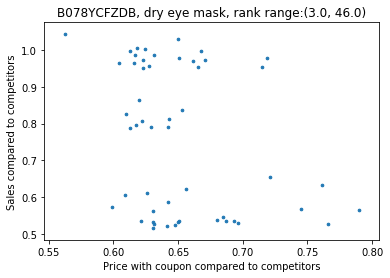

In [146]:
input_asin = 'B078YCFZDB'
kw = 'dry eye mask'

example_slp = pure_slope_df[pure_slope_df['most_common_asin']==input_asin]
example_slp_1w = example_slp[example_slp['keyword']==kw]
date_list = []
rank_list = []
for i in range(len(example_slp_1w)):
    dates_i = example_slp_1w['rank_dates'].iloc[i]
    ranks_i = example_slp_1w['ranks'].iloc[i]
    date_list = date_list + dates_i
    rank_list = rank_list + ranks_i

comps_ls = []

for i in range(len(date_list)):
    d = date_list[i]
    r = rank_list[i]
    compare_dict = compare_to_competitors(input_asin=input_asin, keyword=kw, target_date=d, var_to_compare=['price_with_coupon', 'Sales'])
    if 'price_with_coupon' in compare_dict.keys():
        compare_dict['rank'] = r
        comps_ls.append(compare_dict)
comps_df = merge_dicts_to_df(comps_ls)

plt.scatter(comps_df['price_with_coupon'], comps_df['Sales'], s=7)
plt.xlabel('Price with coupon compared to competitors')
plt.ylabel('Sales compared to competitors')
title_str = input_asin + ', '+ kw + ', rank range:(' + str(min(comps_df['rank'])) +', '+str(max(comps_df['rank']))+ ')'
plt.title(title_str)
plt.show()

comps_df_dryEyeMask = comps_df

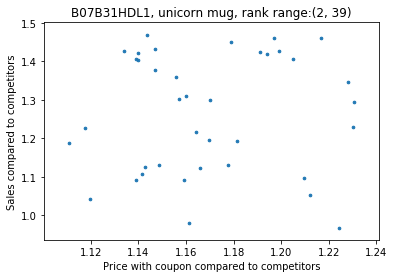

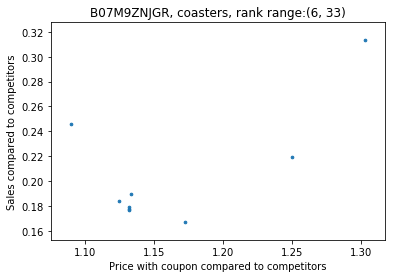

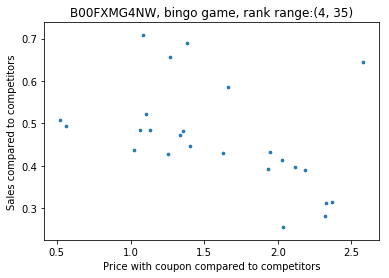

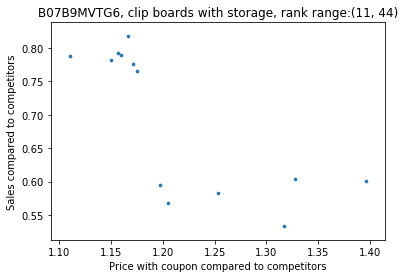

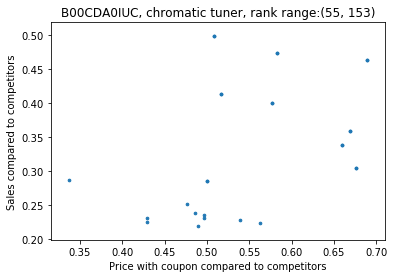

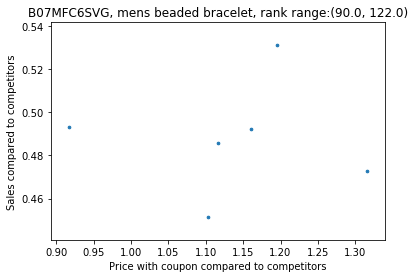

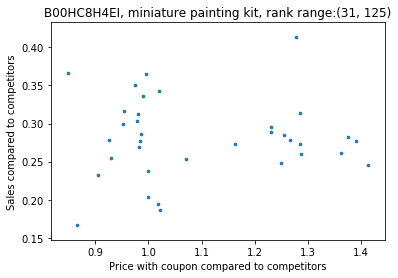

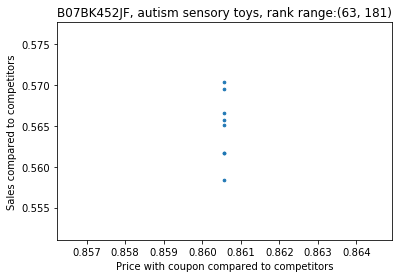

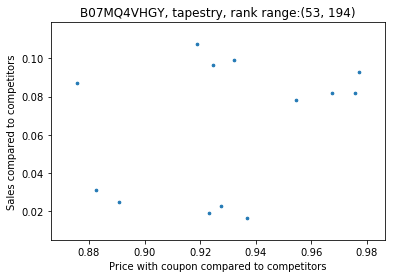

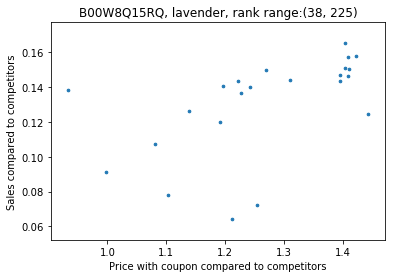

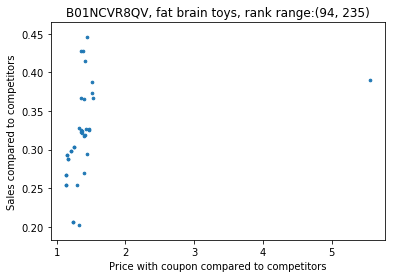

In [149]:
comp_df_list = []
for awpair in [('B07B31HDL1', 'unicorn mug'), ('B07M9ZNJGR', 'coasters'), ('B00FXMG4NW', 'bingo game'), 
               ('B07B9MVTG6', 'clip boards with storage'), ('B00CDA0IUC', 'chromatic tuner'), ('B07MFC6SVG', 'mens beaded bracelet'),
              ('B00HC8H4EI', 'miniature painting kit'), ('B07BK452JF', 'autism sensory toys'), ('B07MQ4VHGY', 'tapestry'), 
              ('B00W8Q15RQ', 'lavender'), ('B01NCVR8QV','fat brain toys')]:
    comp_df = plot_compet_price_vs_sale(awpair[0], awpair[1])
    comp_df_list.append(comp_df)

# Catergorize the rank change based on the original position of product
## - Top ASIN, successful defending
## - Top ASIN, fail defending
## - Middle ASIN, successful climbing
## - Middle ASIN, stay stable
## - Middle ASIN, rank droping
## - Low-rank ASIN, successful climbing
## - Low-rank ASIN, fail climbing

In [13]:
def classify_rank_change(row): # classify the rank change of a campaign
    avg_rank = row['avg_rank']
    slp = row['slope']
    if avg_rank <= 20:
        if slp < 3:
            out_label = 'top_success'
        else:
            out_label = 'top_fail'
    elif avg_rank <= 150:
        if slp < -5:
            out_label = 'mid_success'
        elif slp > 5:
            out_label = 'mid_fail'
        else:
            out_label = 'mid_stable'
    else:
        if slp < -5:
            out_label = 'low_success'
        else:
            out_label = 'low_fail'
    return out_label

In [14]:
pure_slope_df['campaign_label'] = pure_slope_df.apply(classify_rank_change, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
pure_slope_df['campaign_label'].value_counts()

top_success    17127
mid_stable      9849
mid_success      835
low_fail         770
mid_fail         565
low_success      134
top_fail          54
Name: campaign_label, dtype: int64

In [120]:
top_fail = pure_slope_df[pure_slope_df['campaign_label']=='top_fail']

top_fail

,campaign_dates,keyword,num_ads,parent_asin,rank_dates,ranks,record_asin,seller,slope,variation_asins,vt_purity,avg_rank,row_id,most_common_asin,scaled_slope,campaign_label
1588,"[2019-05-03, 2019-05-04, 2019-05-05, 2019-05-0...",dry eye mask,"[2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 0.0, 6.0, 6.0]",B078Y7VQ36,"[2019-05-03, 2019-05-04, 2019-05-05, 2019-05-0...","[8.0, 6.0, 18.0, 8.0, 7.0, 23.0, 35.0, 26.0, 3...","[B078YCFZDB, B078YCFZDB, B078YCFZDB, B078YCFZD...",A2JLGM9DE4Z30V,3.750000,"[B078YCFZDB, B07S1CBDBM, B07CZQ3WQS, B078Y7VQ36]",1.0,18.666667,1588,B078YCFZDB,0.200893,top_fail
3047,"[2019-02-24, 2019-02-25, 2019-02-26, 2019-02-2...",thank you cards gold,"[4, 0, 2, 0, 0]",B07P1ZLVNG,"[2019-02-24, 2019-02-25, 2019-02-26, 2019-02-2...","[9, 9, 8, 22, 26]","[B078861M4V, B078861M4V, B078861M4V, B078861M4...",A33LJ73XG3GVEB,6.058824,"[B078861M4V, B07893BWLF, B07P1ZLVNG]",1.0,14.800000,3047,B078861M4V,0.409380,top_fail
3247,"[2019-04-08, 2019-04-09, 2019-04-10, 2019-04-1...",grow tent fan,"[2, 2, 2, 2, 2, 6]",B07Q4R3V9P,"[2019-04-08, 2019-04-09, 2019-04-10, 2019-04-1...","[12, 15, 18, 20, 24, 28]","[B01L0D0UEQ, B01L0D0UEQ, B01L0D0UEQ, B01L0D0UE...",A3I2VACYSJR5AQ,3.525000,"[B01F7Q1K3W, B00WW4H8XY, B01L0D0UEQ, B01BV573B...",1.0,19.500000,3247,B01L0D0UEQ,0.180769,top_fail
6717,"[2019-02-24, 2019-02-25, 2019-02-27, 2019-02-2...",unicorn mug,"[1, 0, 4, 4, 4, 0, 28, 0]",B07R721B2L,"[2019-02-24, 2019-02-25, 2019-02-26, 2019-02-2...","[3, 2, 3, 14, 11, 11, 14, 26]","[B07B31HDL1, B07B31HDL1, B07B31HDL1, B07B31HDL...",A3KAGCK7T2C7NR,3.163763,"[B07MTL1RLD, B07B31HDL1, B07R721B2L]",1.0,10.500000,6717,B07B31HDL1,0.301311,top_fail
7139,"[2019-04-05, 2019-04-06, 2019-04-08, 2019-04-0...",mattress protector twin xl,"[22, 34, 4, 14, 4, 2, 4, 4, 20]",B01N4DAEAX,"[2019-04-05, 2019-04-06, 2019-04-07, 2019-04-0...","[11, 11, 11, 8, 9, 7, 12, 9, 54]","[B01MYFSZL2, B01MYFSZL2, B01MYFSZL2, B01MYFSZL...",A3GGU3OA5NO9RN,3.536842,"[B01LXOU0YV, B01MYFSZL2, B01LYO1L61, B01F1H8X8...",1.0,14.666667,7139,B01MYFSZL2,0.241148,top_fail
7523,"[2019-04-06, 2019-04-07, 2019-04-08, 2019-04-0...",coasters,"[2, 2, 2, 2, 2, 2, 6, 6, 6]",B07H9G9YXT,"[2019-04-06, 2019-04-07, 2019-04-08, 2019-04-0...","[9, 6, 8, 15, 16, 17, 27, 27, 33]","[B07M9ZNJGR, B07M9ZNJGR, B07M9ZNJGR, B07M9ZNJG...",A29B1GFPZMG04R,3.204947,"[B07H9FLMZ8, B07MP1R9T2, B07H9DGGZC, B07MH6BGN...",1.0,17.555556,7523,B07M9ZNJGR,0.182560,top_fail
8655,"[2019-04-17, 2019-04-18, 2019-04-20, 2019-04-2...",eye protection,"[2, 2, 2, 6, 6]",B01MUHUROV,"[2019-04-19, 2019-04-20, 2019-04-21, 2019-04-2...","[15, 16, 14, 24, 27]","[B01MUHUROV, B01MUHUROV, B01MUHUROV, B01MUHURO...",A3H4IG5YG2M689,3.178571,[B01MUHUROV],1.0,19.200000,8655,B01MUHUROV,0.165551,top_fail
9863,"[2019-04-09, 2019-04-11, 2019-04-12, 2019-04-1...",bovine ovary,"[1, 1, 1, 1, 3]",B0091QXJ66,"[2019-04-09, 2019-04-10, 2019-04-11, 2019-04-1...","[10, 9, 11, 14, 28]","[B0091QXJ66, B0091QXJ66, B0091QXJ66, B0091QXJ6...",A3OLYSHHQKD02C,4.482143,[B0091QXJ66],1.0,14.400000,9863,B0091QXJ66,0.311260,top_fail
11397,"[2019-04-27, 2019-04-28, 2019-04-29, 2019-05-0...",shot put 8 lb,"[2, 2, 0, 0, 12, 2]",B078867TGN,"[2019-04-29, 2019-04-30, 2019-05-01, 2019-05-0...","[4, 4, 4, 6, 65, 2]","[B078867TGN, B078867TGN, B078867TGN, B078867TG...",A2L0LODUJGR5H7,4.722628,[B078867TGN],1.0,14.166667,11397,B078867TGN,0.333362,top_fail
11473,"[2019-06-03, 2019-06-04, 2019-06-05, 2019-06-0...",bingo game,"[3, 2, 2, 3, 3, 3, 1]",B00FXMG4NW,"[2019-06-04, 2019-06-05, 2019-06-06, 2019-06-0...","[10, 10, 11, 10, 12, 10, 35]","[B00FXMG4NW, B00FXMG4NW, B00FXMG4NW, B00FXMG4N...",A2L0LODUJGR5H7,3.500000,[B00FXMG4NW],1.0,14.000000,11473,B00FXMG4NW,0.250000,top_fail


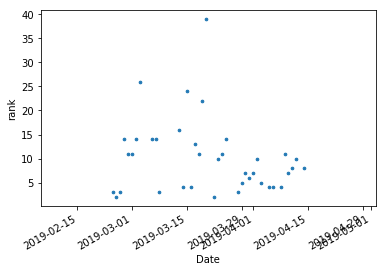

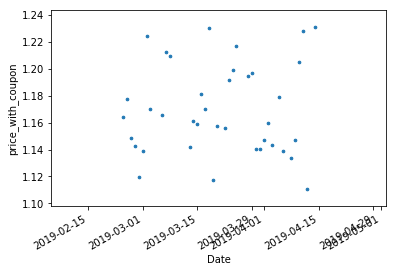

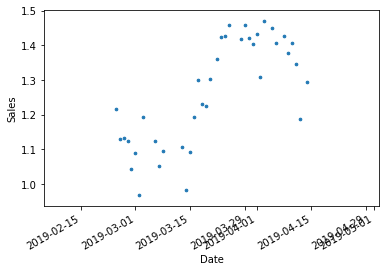

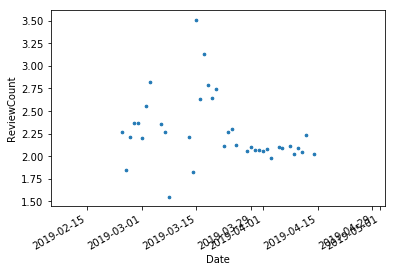

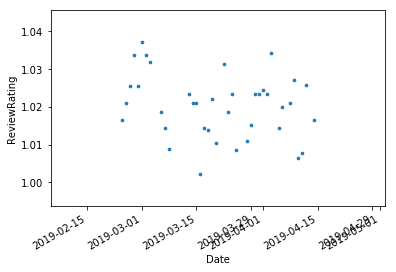

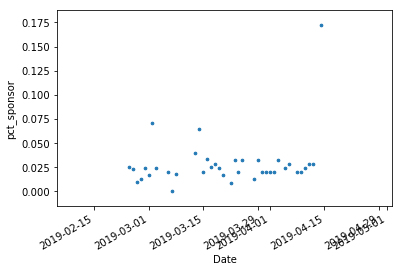

In [127]:
plot_competition('B07B31HDL1', 'unicorn mug')

In [18]:
mid_up = pure_slope_df[pure_slope_df['campaign_label']=='mid_success'].copy()
mid_down = pure_slope_df[pure_slope_df['campaign_label']=='mid_fail'].copy()
mid_up['campaign_label_num'] = 1
mid_down['campaign_label_num'] = 0

mid_sub = pd.concat([mid_up, mid_down]) ######### this combines the good and bad campaigns for asins in the middle rank range

In [20]:
def compete_for_row(row): # calculate the ratios of price/sales/revieweRating... of a ASIN compared to the competitors for a keyword
    try:
        rank_dates = row['rank_dates']
        target_date =  rank_dates[0]
        input_asin = row['most_common_asin']
        keyword = row['keyword']
        return compare_to_competitors(input_asin, keyword, target_date)
    except:
        return {}

# pure_slope_df['compare_dict'] = pure_slope_df.apply(compete_for_row, axis=1)

In [35]:
row_list = [mid_sub.iloc[i] for i in range(len(mid_sub))]

n_jobs = 30

with Pool(n_jobs) as p:
    comp_list = p.map(compete_for_row, row_list)

In [37]:
########### It's very slow to match the data in this way, try other methods
# mid_sub = mid_sub.drop(['compete_price_with_coupon'], axis=1)
mid_sub['compete_price_with_coupon'] = np.NaN
mid_sub['compete_sales'] = np.NaN
mid_sub['compete_reviewcount'] = np.NaN
mid_sub['compete_reviewrating'] = np.NaN
mid_sub['compete_pct_sponsor'] = np.NaN
mid_sub['compete_num_of_comp'] = np.NaN

for i in range(len(mid_sub)):
    comps = comp_list[i]
    if 'price_with_coupon' in comps.keys():
        mid_sub['compete_price_with_coupon'].iloc[i] = comps['price_with_coupon']
        mid_sub['compete_sales'].iloc[i] = comps['Sales']
        mid_sub['compete_reviewcount'].iloc[i] = comps['ReviewCount']
        mid_sub['compete_reviewrating'].iloc[i] = comps['ReviewRating']
        mid_sub['compete_pct_sponsor'].iloc[i] = comps['pct_sponsor']
        mid_sub['compete_num_of_comp'].iloc[i] = comps['num_of_comp']


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
mid_sub_backup = mid_sub.copy()
mid_sub = mid_sub[pd.notnull(mid_sub['compete_price_with_coupon'])]

In [40]:
mid_sub.shape

(1051, 23)

### Load in the keyword network model and use some network features

In [43]:
### read in the network model
G_weighted = nx.read_gpickle("keyword_network_graph.gpickle")

In [60]:
degree_df =  pd.DataFrame(G_weighted.degree())
degree_df.columns = ['keyword', 'degree']
degree_df =  degree_df.sort_values(['degree'], ascending=[False])

w_sum_df =  pd.DataFrame(G_weighted.degree(weight='weight'))
w_sum_df.columns = ['keyword', 'total_weight']
w_sum_df =  w_sum_df.sort_values(['total_weight'], ascending=[False])

In [75]:
import numbers

## find the degree in the network for a keyword
def find_keyw_degree(keyw):
    try:
        out_d = G_weighted.degree(keyw)
        if isinstance(out_d, numbers.Number):
            return out_d
        else:
            return int(degree_df['degree'][degree_df['keyword']==keyw])
    except:
        return 0
## find the sum of relevency score in the network for a keyword
def find_keyw_weight(keyw):
    try:
        out_d = G_weighted.degree(keyw, weight='weight')
        if isinstance(out_d, numbers.Number):
            return out_d
        else:
            return int(w_sum_df['total_weight'][w_sum_df['keyword']==keyw])
    except:
        return 0

In [76]:
## add search_rank, keyword degree, keyword weight_sum
mid_sub['KeywordSearchRank'] = mid_sub['keyword'].apply(find_search_rank)
mid_sub['KeywordDegree'] = mid_sub['keyword'].apply(find_keyw_degree)
mid_sub['KeywordWeight'] = mid_sub['keyword'].apply(find_keyw_weight)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [77]:
mid_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 106 to 45232
Data columns (total 26 columns):
campaign_dates               1051 non-null object
keyword                      1051 non-null object
num_ads                      1051 non-null object
parent_asin                  1051 non-null object
rank_dates                   1051 non-null object
ranks                        1051 non-null object
record_asin                  1051 non-null object
seller                       1051 non-null object
slope                        1051 non-null float64
variation_asins              1051 non-null object
vt_purity                    1051 non-null float64
avg_rank                     1051 non-null float64
row_id                       1051 non-null int64
most_common_asin             1051 non-null object
scaled_slope                 1051 non-null float64
campaign_label               1051 non-null object
campaign_label_num           1051 non-null int64
compete_price_with_coupon    1051 non-

In [81]:
mid_sub['campaign_label'].value_counts()

mid_success    628
mid_fail       423
Name: campaign_label, dtype: int64

In [82]:
# mid_sub.to_csv('middle_rank_campaign_record.csv', index=False)
## load the processed mid_sub.csv file back if needed.

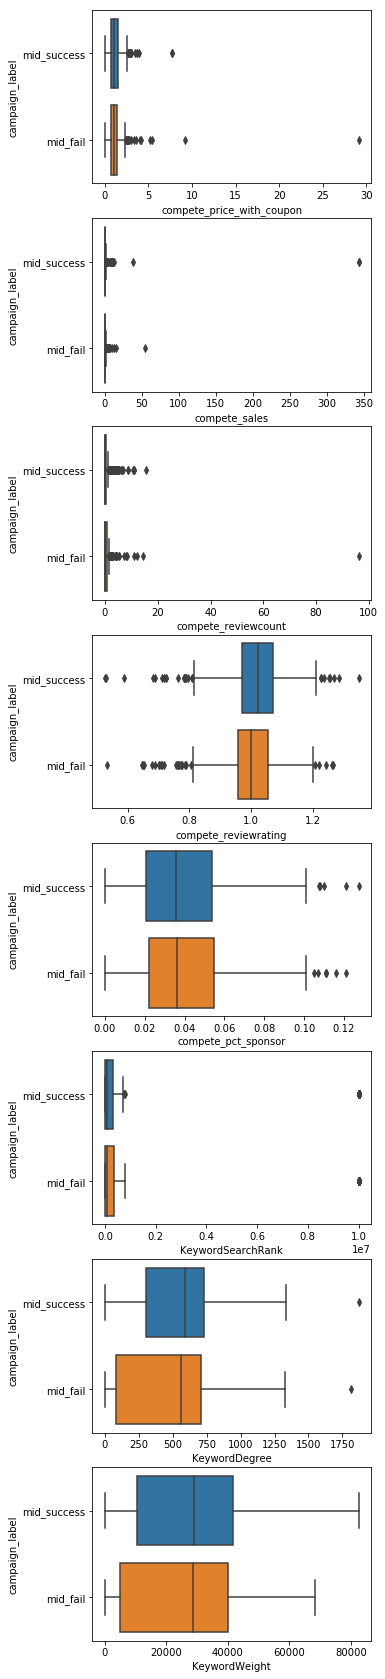

In [102]:
fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(5, 30))
for i in range(8):
    col = ['compete_price_with_coupon', 'compete_sales', 'compete_reviewcount', 'compete_reviewrating', 'compete_pct_sponsor', 'KeywordSearchRank', 
           'KeywordDegree', 'KeywordWeight'][i]
    
    sns.boxplot(y='campaign_label', x=col, data=mid_sub, ax=axs[i], order=['mid_success', 'mid_fail'])

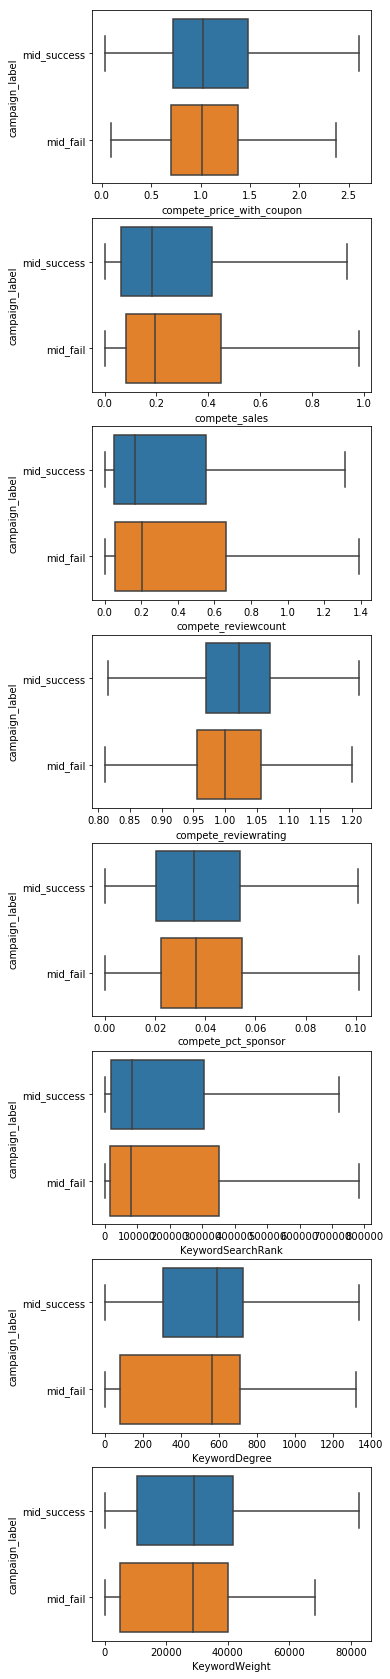

In [80]:
## this boxplot removed the outliers.
fig, axs = plt.subplots(nrows=8, ncols=1, figsize=(5, 30))
for i in range(8):
    col = ['compete_price_with_coupon', 'compete_sales', 'compete_reviewcount', 'compete_reviewrating', 'compete_pct_sponsor', 'KeywordSearchRank', 
           'KeywordDegree', 'KeywordWeight'][i]
    
    sns.boxplot(y='campaign_label', x=col, data=mid_sub, ax=axs[i], order=['mid_success', 'mid_fail'], showfliers=False)

In [84]:
mid_sub_rf = mid_sub[['campaign_label_num', 'compete_price_with_coupon',
       'compete_sales', 'compete_reviewcount', 'compete_reviewrating',
       'compete_pct_sponsor', 'KeywordSearchRank',
       'KeywordDegree', 'KeywordWeight']]

In [89]:
### now also apply the feature importance of random forest
def rf_importance_mid(target_v, input_df, small_data = False, figure_size=(10,27)): #target_v = 'slope_label', 'slope', 'scaled_slope'
    pure_df = input_df
    p_df1 = pure_df
#     if target_v == 'scaled_slope':
#         p_df1 = pure_df.drop(columns=['slope', 'slope_label'])
#     elif target_v == 'slope':
#         p_df1 = pure_df.drop(columns=['scaled_slope','slope_label'])
#     else:
#         p_df1 = pure_df.drop(columns=['scaled_slope','slope'])
    # Randomly select 1000 rows for testing, keep the rest for training
    if small_data:
        test = p_df1.sample(n=10)
    else:
        test=p_df1.sample(n=1000)
    train=p_df1.loc[~p_df1.index.isin(test.index)]

    train_x=train.loc[:,train.columns!=target_v]
    train_y=train[target_v]
    test_x=test.loc[:,test.columns!=target_v]
    test_y=test[target_v]
    #Random Forest
    if target_v == 'campaign_label_num':
        rf=RandomForestClassifier(n_estimators=10,bootstrap=True, random_state=0) ## number of trees and number of layers/depth
    else:
        rf=RandomForestRegressor(n_estimators=10,bootstrap=True, random_state=0) ## number of trees and number of layers/depth
    rf.fit(train_x,train_y)
    rf_tr=rf.predict(train_x)
    rf_y=rf.predict(test_x)

    feature_importance = rf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_to_show = len(test_x.columns)
    indices = np.argsort(feature_importance)[-feature_to_show:]
    plt.figure(figsize=figure_size)
    plt.barh(np.arange(feature_to_show), feature_importance[indices],color='dodgerblue',alpha=.4)
    plt.yticks(np.arange(feature_to_show + 0.25), np.array(train_x.columns)[indices])
    plt.xlabel('Relative importance'), plt.title('Top Important Variables, target: '+target_v)
    plt.show()
    return list(train_x.columns), feature_importance

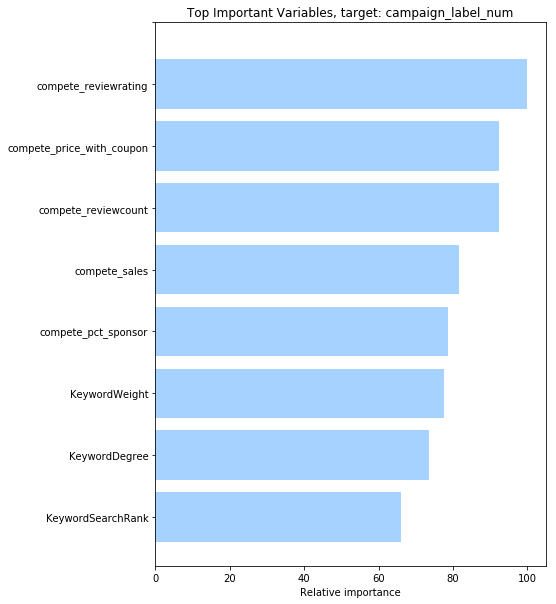

In [93]:
col_mid, imp_mid = rf_importance_mid(target_v = 'campaign_label_num', input_df=mid_sub_rf, small_data=True, figure_size=(7,10))

In [101]:
## t-test
from scipy.stats import ttest_ind

for col in ['compete_price_with_coupon',
       'compete_sales', 'compete_reviewcount', 'compete_reviewrating',
       'compete_pct_sponsor', 'KeywordSearchRank',
       'KeywordDegree', 'KeywordWeight']:
    good = mid_sub[col][mid_sub['campaign_label']=='mid_success']
    bad = mid_sub[col][mid_sub['campaign_label']=='mid_fail']
    t, p = ttest_ind(good, bad, equal_var=False)
    print('Variable: {}'.format(col))
    print('Average of Good Campaigns {}, Average of Bad Campaigns {}'.format(np.mean(good), np.mean(bad)))
    print('t statistic = %g, p value = %g' % (t, p))
    print('******************************************************')

Variable: compete_price_with_coupon
Average of Good Campaigns 1.1569721127020813, Average of Bad Campaigns 1.1966668043981312
t statistic = -0.492556, p value = 0.622528
******************************************************
Variable: compete_sales
Average of Good Campaigns 1.66038495551496, Average of Bad Campaigns 0.6595740163491062
t statistic = 1.27056, p value = 0.204329
******************************************************
Variable: compete_reviewcount
Average of Good Campaigns 0.6652279016880149, Average of Bad Campaigns 0.8856827400590384
t statistic = -0.906719, p value = 0.365017
******************************************************
Variable: compete_reviewrating
Average of Good Campaigns 1.0148580680552937, Average of Bad Campaigns 0.9964159686417586
t statistic = 2.9045, p value = 0.00377017
******************************************************
Variable: compete_pct_sponsor
Average of Good Campaigns 0.03827277193127146, Average of Bad Campaigns 0.04015696684569719
t stat

## PPC data from campaign API

In [ ]:
# ## now look at the original data from campaign API, use the eye mask as one example
# c = Campaign(marketplace,account_name,account_key)
# seller = 'A2JLGM9DE4Z30V'
# # avai_camp_dates = c.GetReportDates(seller=seller)
# date_from = pd.to_datetime('2019-04-26')
# date_to =   pd.to_datetime('2019-04-27')
# d = c.GetCampaignData(seller=seller,
#                             date_from = date_from,
#                             date_to = date_to,
#                             Get_Asin=True,
#                             Get_ProductAd=True,
#                             Get_Keyword=True,
#                             Get_Campaign=True,
#                             Get_AdGroup=True,
#                             Get_ProductAttributeTargeting=True,

#                             Get_SponsoredProducts=True,
#                             Get_SponsoredBrands=False,

#                             Get_Suffix_Query=False,
#                             Get_Suffix_Placement=False)
# d_asin = d['Asin_SponsoredProducts']
# d_asin[d_asin['Report_Asin']=='B078YCFZDB']
# d_keyword = d['Keyword_SponsoredProducts']
# # d_keyword[(d_keyword['Report_CampaignID']=='100419000945352') & (d_keyword['ReportDate']=='2019-04-13')]
# d_keyw_sub = d_keyword[(d_keyword['Report_CampaignID']=='100419000945352')]
# keyw_summary = d_keyw_sub.groupby(['Report_KeywordText'])['Report_AttributedSales1d','Report_Cost'].sum()

# def cal_sale_over_cost(row): # calculate the attributed sales/cost
#     s = row['Report_AttributedSales1d']
#     c = row['Report_Cost']
#     if s == 0:
#         ratio = 0
#     else:
#         ratio = s/c
#     return ratio
# keyw_summary['SaleCostRatio'] = keyw_summary.apply(cal_sale_over_cost, axis=1)

# keyw_summary.to_csv('PPC_sales_cost_eye_mask.csv', index=True)

In [156]:
PPC_eye_mask = pd.read_csv('PPC_sales_cost_eye_mask.csv')

PPC_eye_mask['KeywordSearchRank'] = PPC_eye_mask['Report_KeywordText'].apply(find_search_rank)
PPC_eye_mask['KeywordDegree'] = PPC_eye_mask['Report_KeywordText'].apply(find_keyw_degree)
PPC_eye_mask['KeywordWeight'] = PPC_eye_mask['Report_KeywordText'].apply(find_keyw_weight)

PPC_eye_mask

,Report_KeywordText,Report_AttributedSales1d,Report_Cost,SaleCostRatio,KeywordSearchRank,KeywordDegree,KeywordWeight
0,blepharitis treatment,243.96,115.92,2.104555,125282,746,52804.50
1,bruder eye compress moist heat,0.00,1.33,0.000000,81398,533,68915.23
2,bruder eye mask,27.94,28.55,0.978634,326239,41,3539.67
3,meibomian gland expressor,33.93,11.69,2.902481,10000000,4,54.64
4,ocusoft lid scrub plus,44.91,45.10,0.995787,44350,645,82408.93
5,retaine mgd,0.00,0.00,0.000000,349389,385,38105.75
6,stye treatment,0.00,2.61,0.000000,81071,628,30136.59
7,warm compress eye mask,0.00,0.00,0.000000,10000000,30,3668.72
8,warm eye compress for dry eyes,0.00,0.00,0.000000,10000000,0,0.00
9,we love eyes,97.64,61.43,1.589451,193866,423,24633.67


In [157]:
def comp_to_comp_apply(row): # for each keyword, find the ratio compared to competitors
    comp_dict = compare_to_competitors(input_asin='B078YCFZDB', keyword=row['Report_KeywordText'], target_date='2019-04-26')
    return comp_dict

PPC_eye_mask['comp_dict'] = PPC_eye_mask.apply(comp_to_comp_apply, axis=1)
PPC_eye_mask

,Report_KeywordText,Report_AttributedSales1d,Report_Cost,SaleCostRatio,KeywordSearchRank,KeywordDegree,KeywordWeight,comp_dict
0,blepharitis treatment,243.96,115.92,2.104555,125282,746,52804.50,"{'price_with_coupon': 0.6562751162960618, 'Sal..."
1,bruder eye compress moist heat,0.00,1.33,0.000000,81398,533,68915.23,"{'price_with_coupon': 0.6178411786353428, 'Sal..."
2,bruder eye mask,27.94,28.55,0.978634,326239,41,3539.67,"{'price_with_coupon': 0.6890960888311504, 'Sal..."
3,meibomian gland expressor,33.93,11.69,2.902481,10000000,4,54.64,{}
4,ocusoft lid scrub plus,44.91,45.10,0.995787,44350,645,82408.93,"{'price_with_coupon': 0.4681945337341234, 'Sal..."
5,retaine mgd,0.00,0.00,0.000000,349389,385,38105.75,"{'price_with_coupon': 0.38022802957611324, 'Sa..."
6,stye treatment,0.00,2.61,0.000000,81071,628,30136.59,"{'price_with_coupon': 0.7092752141441094, 'Sal..."
7,warm compress eye mask,0.00,0.00,0.000000,10000000,30,3668.72,"{'price_with_coupon': 0.7203146865765003, 'Sal..."
8,warm eye compress for dry eyes,0.00,0.00,0.000000,10000000,0,0.00,"{'price_with_coupon': 0.736118889237956, 'Sale..."
9,we love eyes,97.64,61.43,1.589451,193866,423,24633.67,"{'price_with_coupon': 0.500829829245413, 'Sale..."


In [158]:
for col in ['price_with_coupon', 'Sales', 'ReviewCount', 'ReviewRating', 'pct_sponsor']:
    v_list = [d[col] if col in d.keys() else np.NaN for d in PPC_eye_mask['comp_dict']]
    PPC_eye_mask[col] = v_list

In [161]:
PPC_eye_mask = PPC_eye_mask.drop(columns=['comp_dict'])
PPC_eye_mask = PPC_eye_mask[pd.notnull(PPC_eye_mask['price_with_coupon'])]
PPC_eye_mask

,Report_KeywordText,Report_AttributedSales1d,Report_Cost,SaleCostRatio,KeywordSearchRank,KeywordDegree,KeywordWeight,price_with_coupon,Sales,ReviewCount,ReviewRating,pct_sponsor
0,blepharitis treatment,243.96,115.92,2.104555,125282,746,52804.50,0.656275,0.348608,0.205361,0.955711,0.012346
1,bruder eye compress moist heat,0.00,1.33,0.000000,81398,533,68915.23,0.617841,0.635884,0.336224,0.935361,0.014286
2,bruder eye mask,27.94,28.55,0.978634,326239,41,3539.67,0.689096,0.759052,0.464775,0.908985,0.032258
4,ocusoft lid scrub plus,44.91,45.10,0.995787,44350,645,82408.93,0.468195,0.365476,0.195312,0.930760,0.010929
5,retaine mgd,0.00,0.00,0.000000,349389,385,38105.75,0.380228,0.360862,0.245256,0.947689,0.039683
6,stye treatment,0.00,2.61,0.000000,81071,628,30136.59,0.709275,0.490155,0.340952,0.948843,0.012195
7,warm compress eye mask,0.00,0.00,0.000000,10000000,30,3668.72,0.720315,1.027410,0.464434,0.936073,0.016393
8,warm eye compress for dry eyes,0.00,0.00,0.000000,10000000,0,0.00,0.736119,1.079397,0.448748,0.957944,0.000000
9,we love eyes,97.64,61.43,1.589451,193866,423,24633.67,0.500830,1.719058,0.445149,0.954876,0.022814


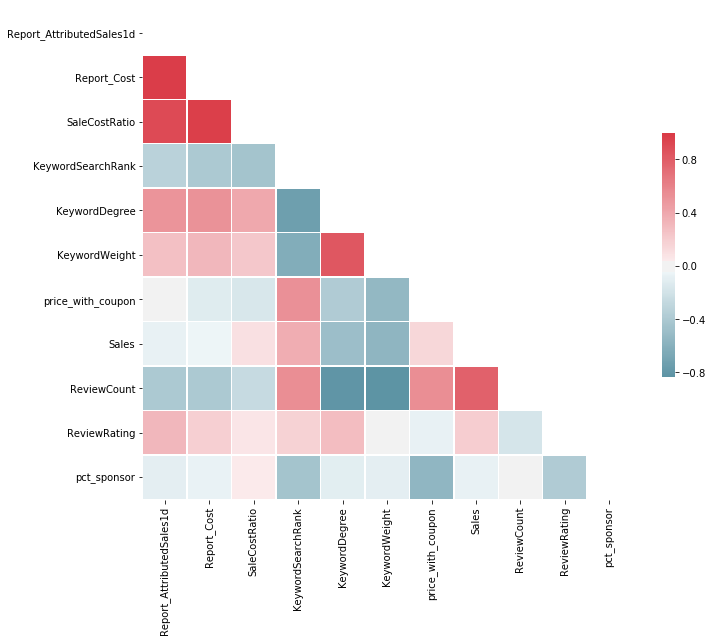

In [163]:
# Compute the correlation matrix
corr = PPC_eye_mask.drop(columns=['Report_KeywordText']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})